In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import sweetviz as sv
import warnings 
warnings.filterwarnings("ignore")
import seaborn as sns


sns.set_palette("colorblind")
sns.set(font_scale = 1.3)
sns.set_style("whitegrid")

In [140]:
survey_vitals = pd.read_csv("survey_vitals_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
eval_med = pd.read_csv("evaluation_medical_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()
history_env = pd.read_csv("history_env_clean.csv").drop(columns = 'Unnamed: 0').drop_duplicates()

In [141]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


In [142]:
print(survey_vitals.shape)
print(eval_med.shape)
print(history_env.shape)

(9458, 10)
(8263, 7)
(5472, 16)


# Clustering based on geopoint data

In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sns
from sklearn.impute import SimpleImputer

In [144]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude city province   age     sex  
0 -70.743801  NaN      NaN  34.0  female  
1 -70.744104  NaN      NaN  52.0  female  
2 -70.744016  NaN      NaN  39.0    male  
3 -70.744557  NaN      NaN  39.0  female  
4 -70.745053  NaN      NaN  23.0    male

In [145]:
geo_loc = survey_vitals.loc[:, ["latitude", "longitude"]]

In [146]:
scaler = StandardScaler()

In [147]:
transformed_geo = scaler.fit_transform(geo_loc)

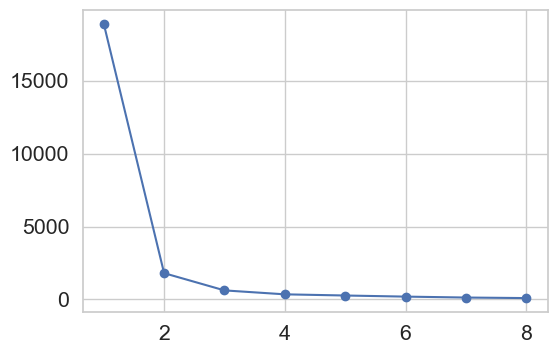

In [148]:
inertias = []
num_clusters = [1,2,3,4,5,6,7,8]
for k in num_clusters:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(transformed_geo)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, "-o")

In [149]:
model_KMeans =  KMeans(n_clusters = 4, random_state = 42)
labels = model_KMeans.fit_predict(transformed_geo)
labels

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [150]:
survey_vitals["clustersByLoc"] = list(labels)
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude city province   age     sex  clustersByLoc  
0 -70.743801  NaN      NaN  34.0  female              1  
1 -70.744104  NaN      NaN  52.0  female              1  
2 -70.744016  NaN      NaN  39.0    male              1  
3 -70.744557  NaN      NaN  39.0  female              1  
4 -70.745053  NaN      NaN  23.0    male              1

In [151]:
def province_clean(cluster):
    if cluster == 0:
        return "Lavega"
    elif cluster == 1:
        return "San Pedro de Macoris"
    elif cluster == 2:
        return "Santiago"
    else:
        return "San Pedro de Macoris/North"

In [152]:
survey_vitals = survey_vitals.drop(columns = ["city", "province"], axis = 1)
survey_vitals["province"] = survey_vitals["clustersByLoc"].apply(province_clean)

In [153]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude   age     sex  clustersByLoc              province  
0 -70.743801  34.0  female              1  San Pedro de Macoris  
1 -70.744104  52.0  female              1  San Pedro de Macoris  
2 -70.744016  39.0    male              1  San Pedro de Macoris  
3 -70.744557  39.0  female              1  San Pedro de Macoris  
4 -70.745053  23.0    male              1  San Pedro de Macoris

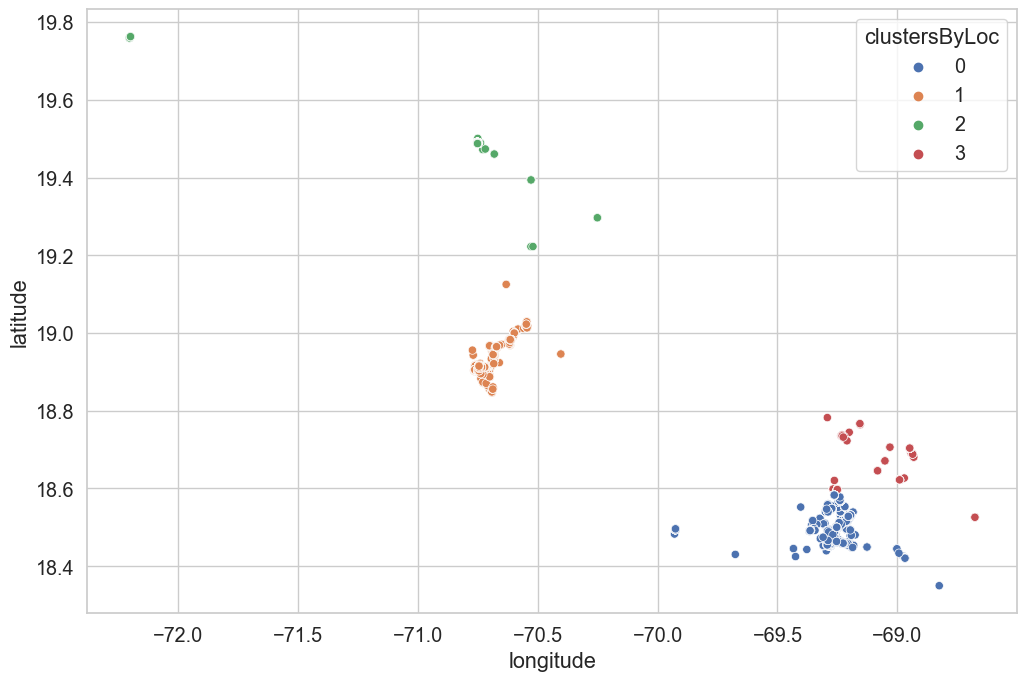

In [198]:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(data = survey_vitals, x = "longitude", y = "latitude", hue = "clustersByLoc", palette = "deep")

# Dealing with missing values: survey_vitals

### 1. survey_vitals

In [155]:
survey_vitals.shape

(9458, 10)

In [156]:
# delete marriagestatus

In [157]:
survey_vitals.isna().sum()

objectId             0
marriageStatus    1597
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                482
sex                  0
clustersByLoc        0
province             0
dtype: int64


In [158]:
# filling missing values in marriageStatus column based on distribution
s = survey_vitals.marriageStatus.value_counts(normalize = True)
s

single        0.452487
free_union    0.340287
married       0.127465
widow         0.042743
concubine     0.037018
Name: marriageStatus, dtype: float64


In [159]:
missing = survey_vitals["marriageStatus"].isnull()
survey_vitals.loc[missing, "marriageStatus"] = np.random.choice(s.index, size=len(survey_vitals[missing]),p=s.values)

In [160]:
survey_vitals.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  XHCkKebF4a         single  Ama de casa  lessThanprimary  18.912087   
1  ITCa1BkIiK         single  Ama de casa   someHighSchool  18.913084   
2  AKjkw9A25J         single        Other   someHighSchool  18.913084   
3  jk3fDkMvN9         single  Ama de casa  lessThanprimary  18.913325   
4  pPgDn3kfGL         single   Estudiante   someHighSchool  18.913523   

   longitude   age     sex  clustersByLoc              province  
0 -70.743801  34.0  female              1  San Pedro de Macoris  
1 -70.744104  52.0  female              1  San Pedro de Macoris  
2 -70.744016  39.0    male              1  San Pedro de Macoris  
3 -70.744557  39.0  female              1  San Pedro de Macoris  
4 -70.745053  23.0    male              1  San Pedro de Macoris

In [161]:
age_dict = survey_vitals.groupby("marriageStatus")["age"].median().to_dict()
age_dict

{'concubine': 38.0,
 'free_union': 37.0,
 'married': 47.0,
 'single': 29.0,
 'widow': 66.0}

In [162]:
unknown_age = survey_vitals["age"].isnull()
survey_vitals.loc[unknown_age, "age"] = survey_vitals.loc[unknown_age, "marriageStatus"].map(age_dict)

In [163]:
survey_vitals.isna().sum()

objectId             0
marriageStatus       0
occupation           0
educationLevel    1486
latitude             0
longitude            0
age                  0
sex                  0
clustersByLoc        0
province             0
dtype: int64


### Predicting educationLevel missing values

In [164]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [165]:
train_data = survey_vitals.dropna().drop(columns = ["latitude", "longitude", "clustersByLoc", "objectId"])
X_train = train_data.drop(columns = "educationLevel")
y_train = train_data["educationLevel"]
X_test = survey_vitals.loc[survey_vitals.educationLevel.isnull()].drop(columns = ["latitude", "longitude", "clustersByLoc", "objectId", "educationLevel"])

In [166]:
num_attribs = list(X_train.select_dtypes(include = [np.number]))
cat_attribs = list(X_train.select_dtypes(exclude = [np.number]))

In [167]:
numeric_transformer = Pipeline([
    ("imp", SimpleImputer(strategy = "mean")),
    ("scale", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imp", SimpleImputer(strategy = "most_frequent")),
    ("onehot", OneHotEncoder(drop = "if_binary"))
])

variable_trans_pipeline = ColumnTransformer([
    ("num", numeric_transformer, num_attribs),
    ("cat", categorical_transformer, cat_attribs)
])


prepared_train_X = variable_trans_pipeline.fit_transform(X_train)

In [168]:
X_test_prepared = variable_trans_pipeline.transform(X_test)

In [169]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=42)
k_neigh_model = KNeighborsClassifier()
svc_model = SVC(gamma="scale",kernel="rbf", random_state = 42)

In [170]:
voting_model = VotingClassifier([
    ("k_nearest", k_neigh_model), 
    ("SVC", svc_model), 
    ("random_forest", rf_model),
], voting = "hard", weights=[1,1,1])

In [171]:
voting_model = voting_model.fit(prepared_train_X,y_train)

In [172]:
accuracy = voting_model.score(prepared_train_X, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.94%


In [173]:
y_test_pred = voting_model.predict(X_test_prepared)

In [174]:
y_test_pred

array(['lessThanprimary', 'lessThanprimary', 'lessThanprimary', ...,
       'lessThanprimary', 'lessThanprimary', 'someHighSchool'],
      dtype=object)

In [175]:
survey_vitals.loc[survey_vitals.educationLevel.isnull(), "educationLevel"] = y_test_pred

In [176]:
survey_vitals.isna().sum()

objectId          0
marriageStatus    0
occupation        0
educationLevel    0
latitude          0
longitude         0
age               0
sex               0
clustersByLoc     0
province          0
dtype: int64



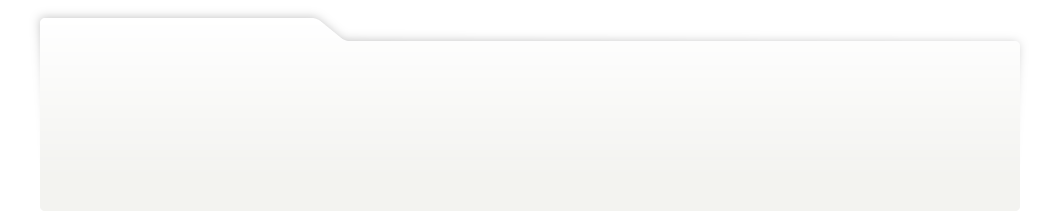
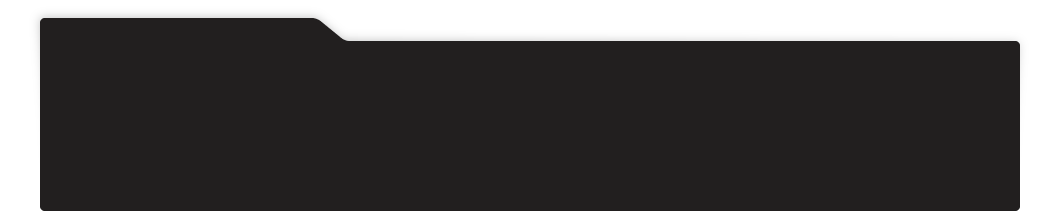
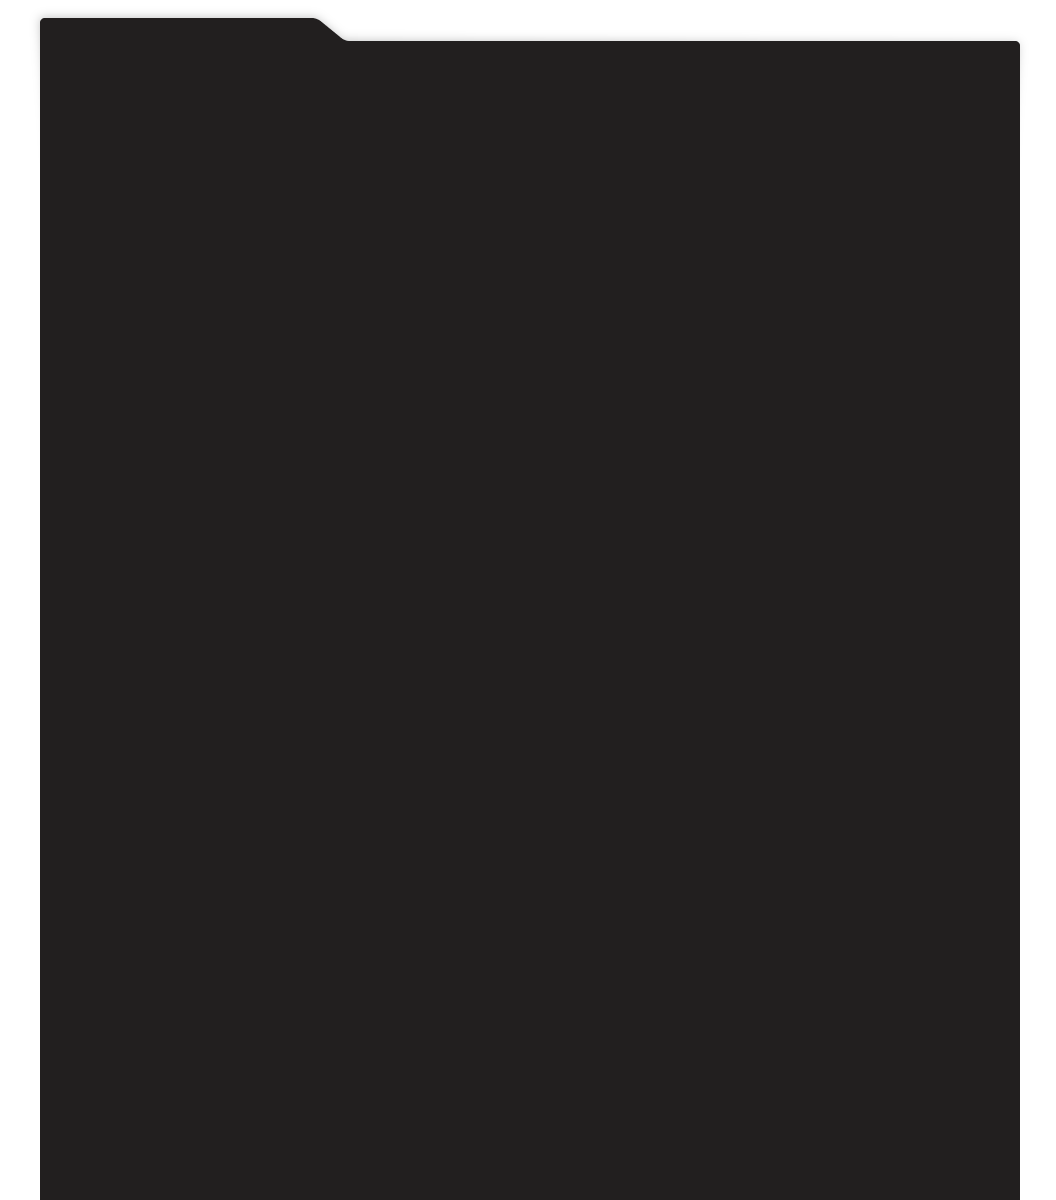
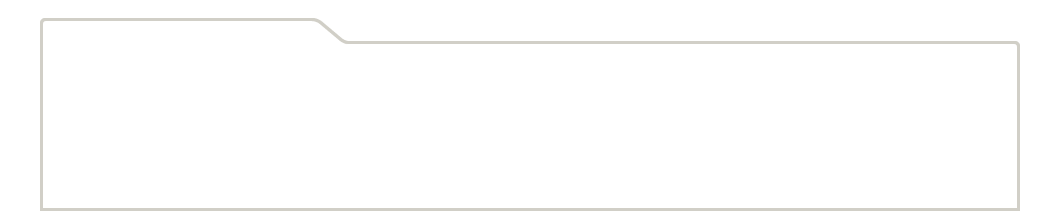
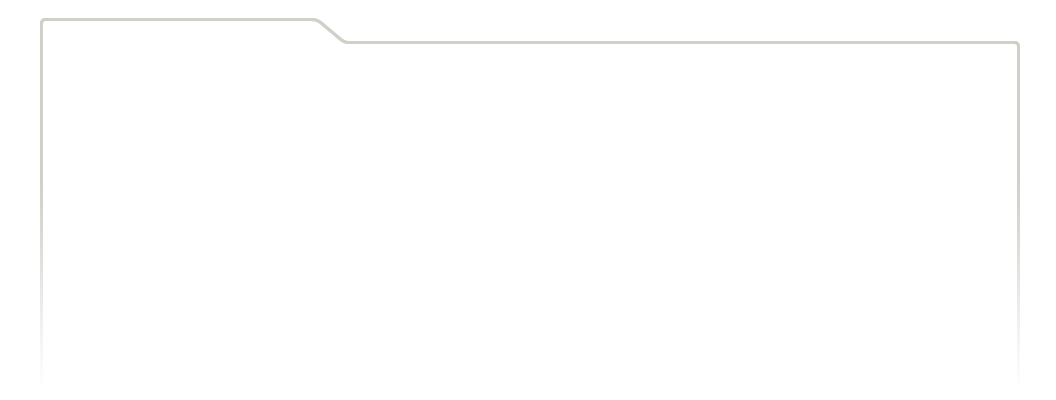
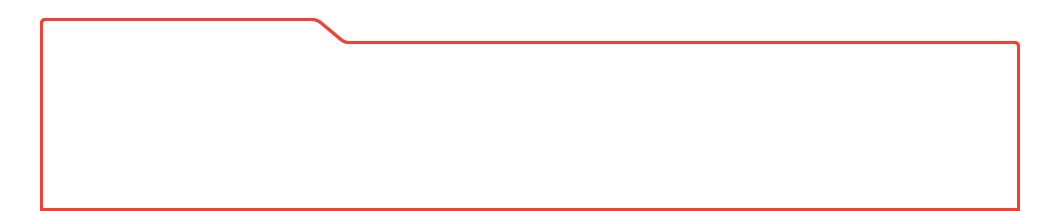
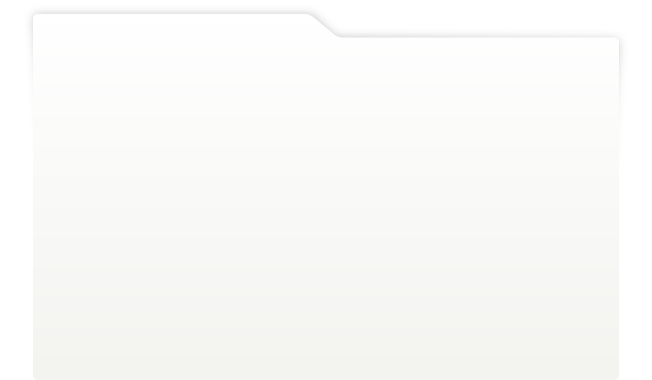
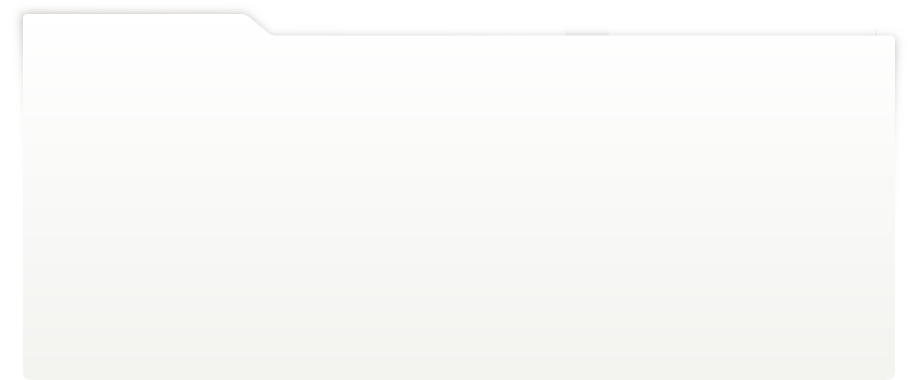
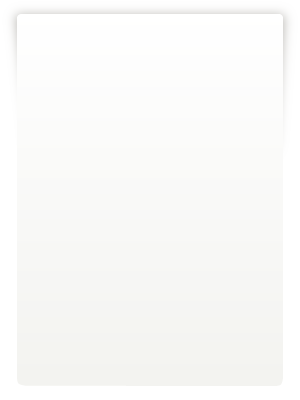
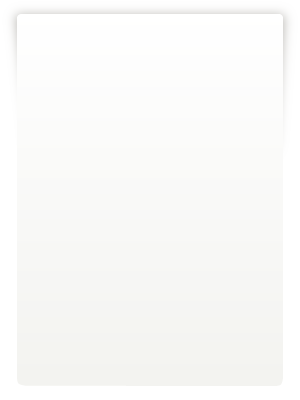
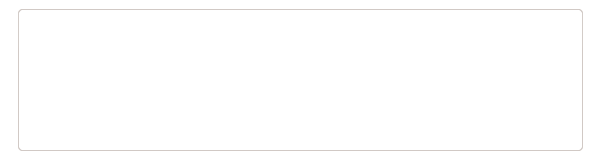
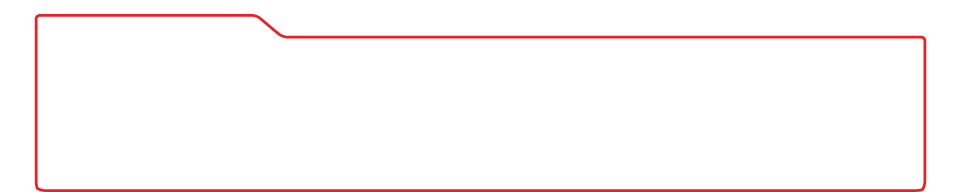
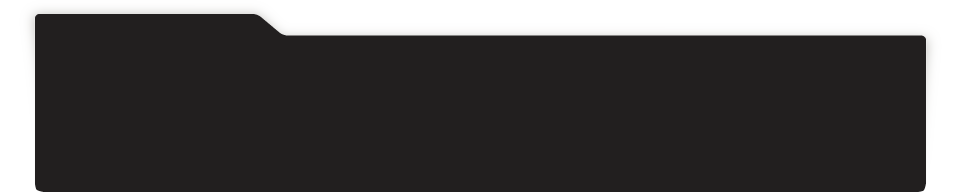
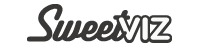
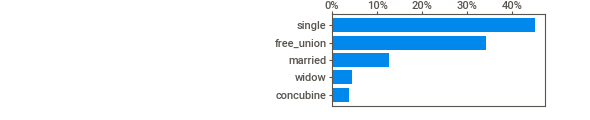
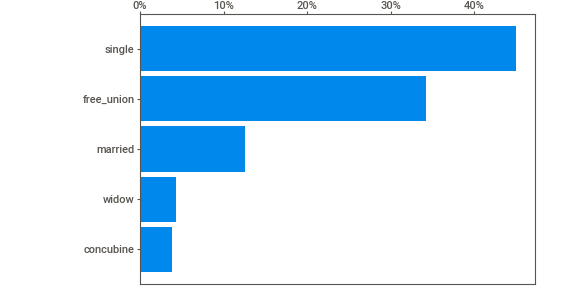
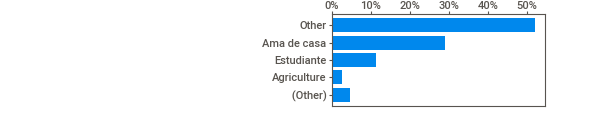
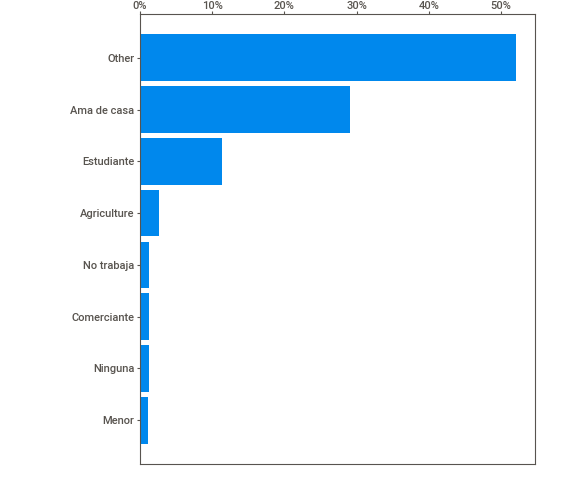
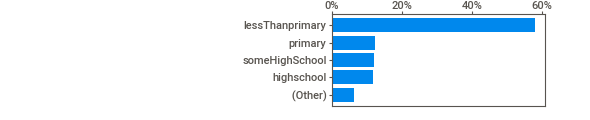
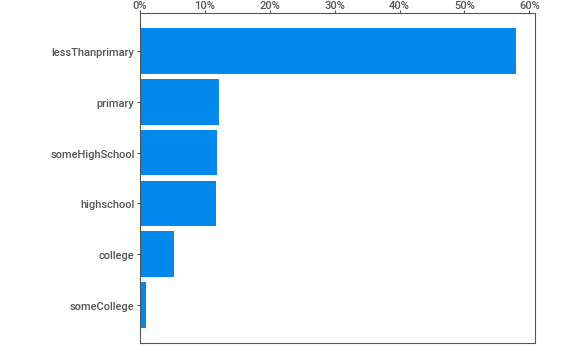
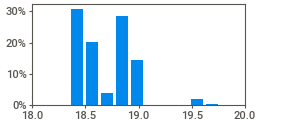
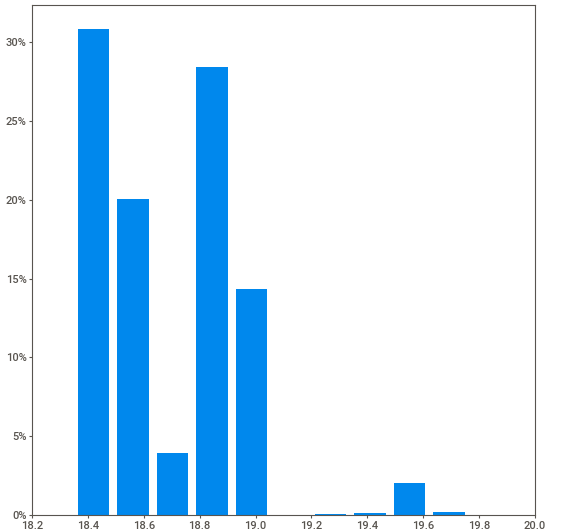
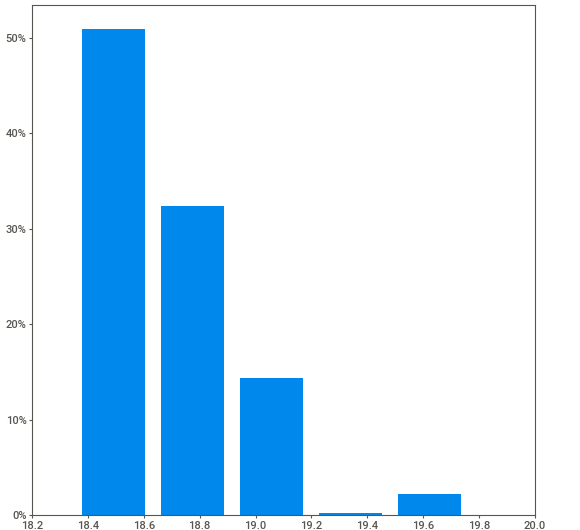
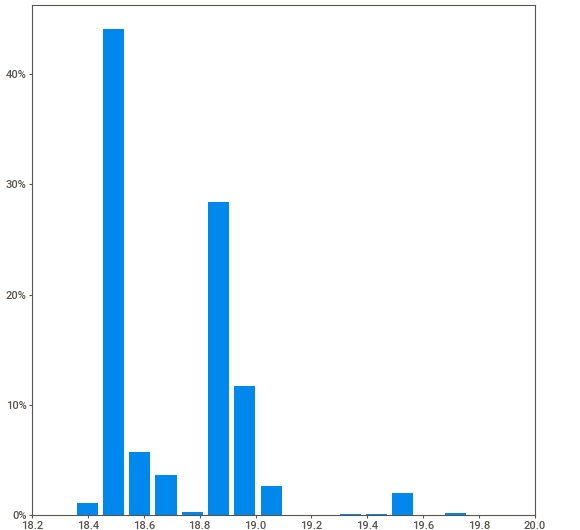
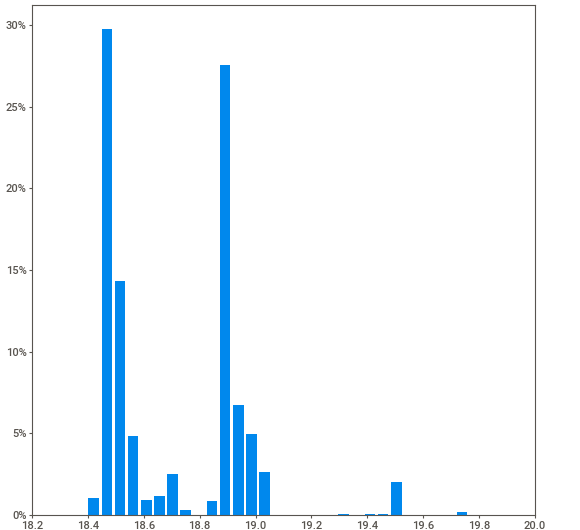
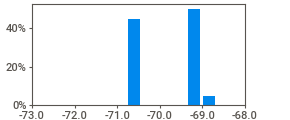
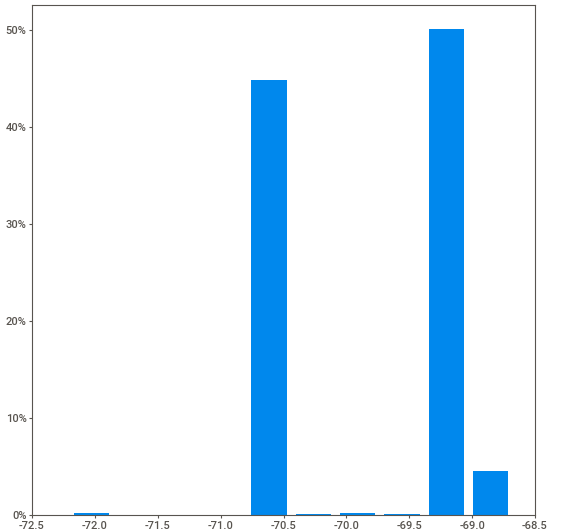
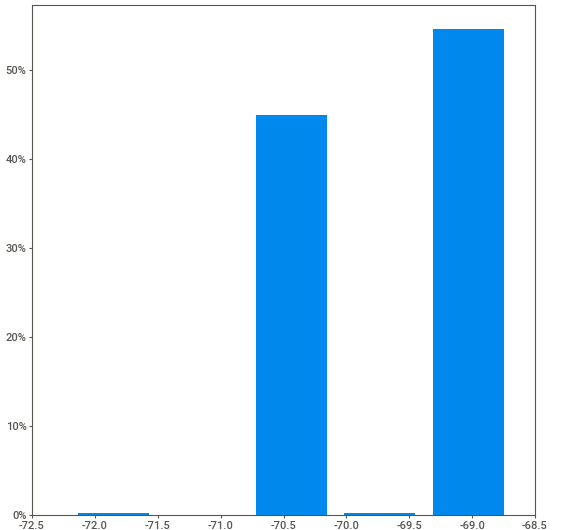
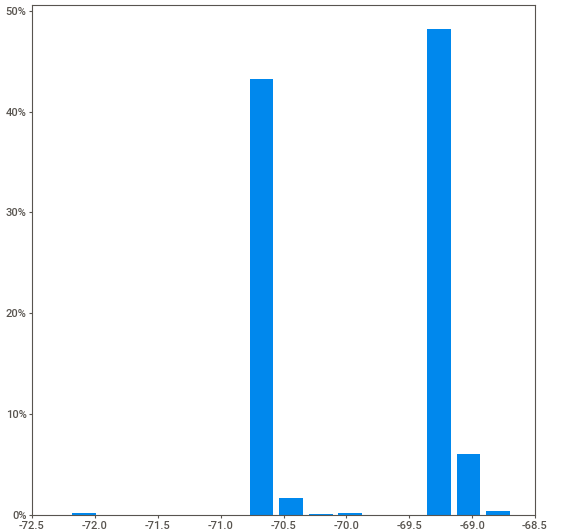
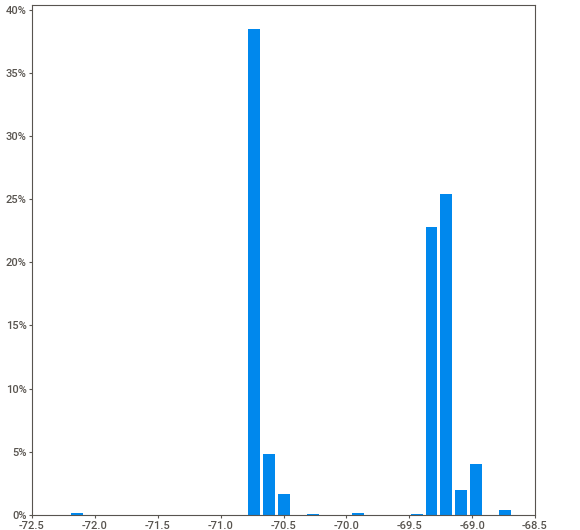
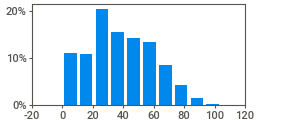
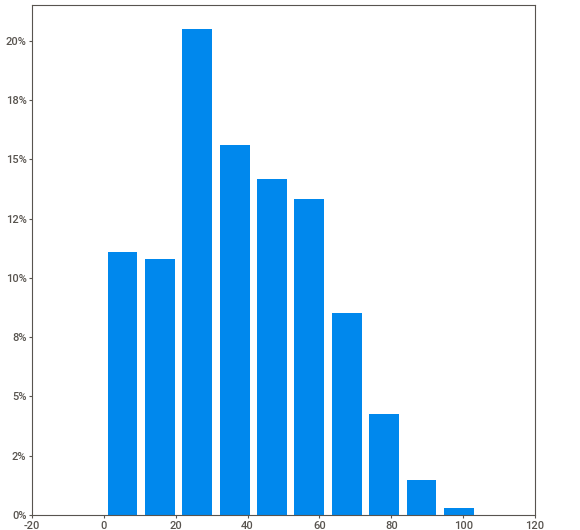
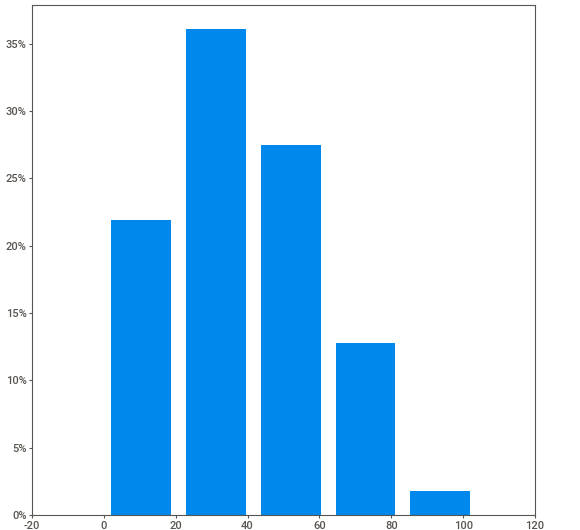
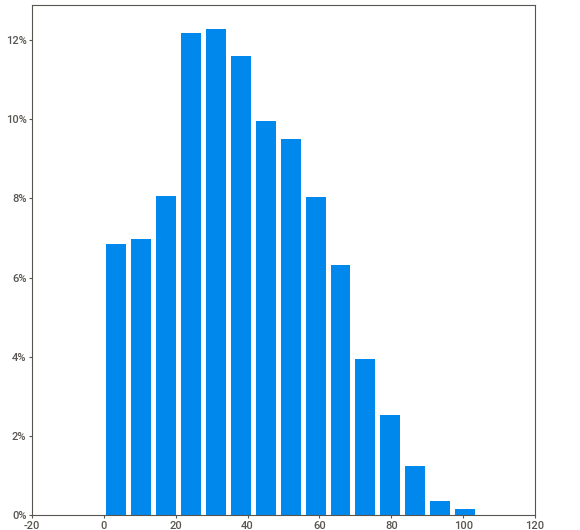
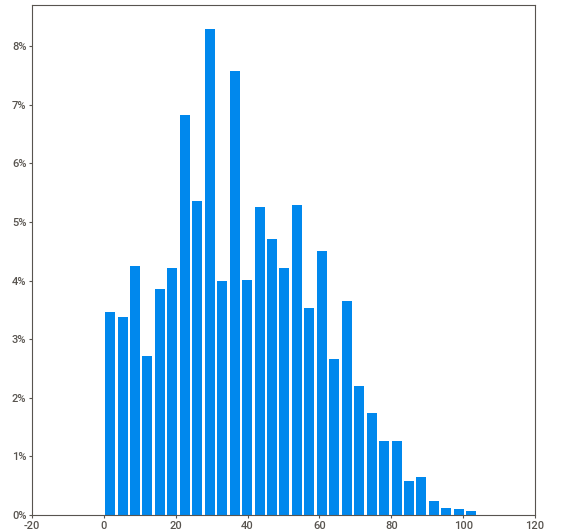
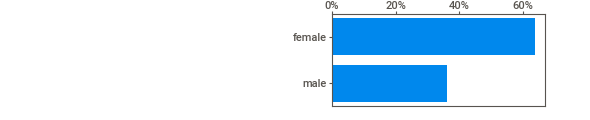
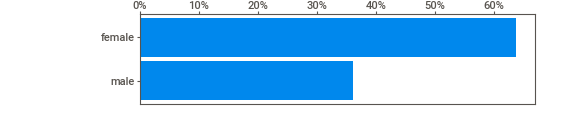
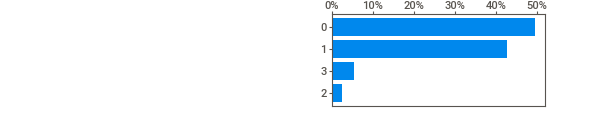
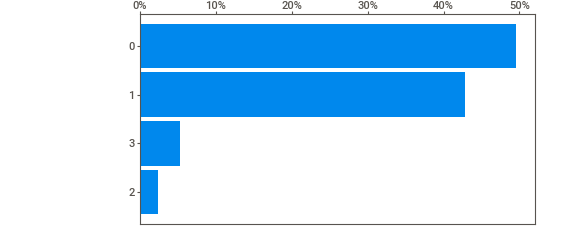
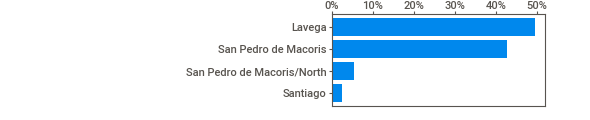
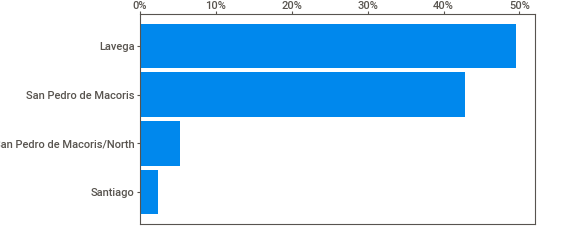
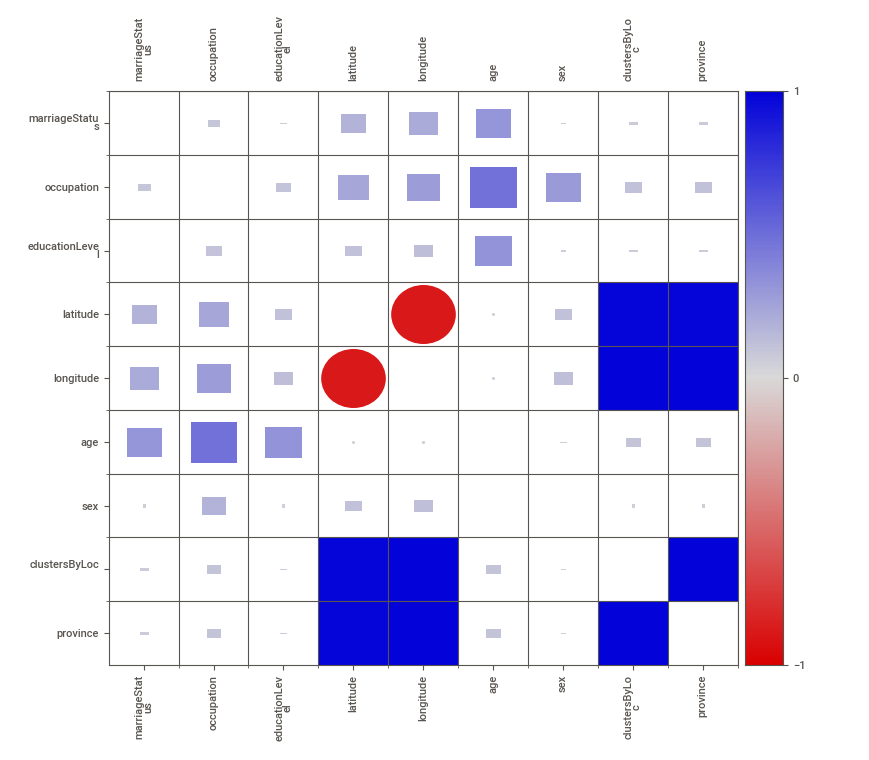
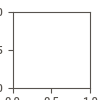

In [177]:
sv_report_survey_vitals = sv.analyze([survey_vitals, "Survey_vitals"])
sv_report_survey_vitals.show_notebook()

### 2. eval_med

In [178]:
eval_med.shape

(8263, 7)

In [179]:
eval_med.isna().sum()

objectId                      0
AssessmentandEvaluation       0
planOfAction                  0
duration                    694
part_of_body               1491
trauma_induced              803
condition_progression       825
dtype: int64


In [180]:
values = {"marriageStatus": , "educationLevel": , "age": survey_vitals.age.mean()}

SyntaxError: invalid syntax (<ipython-input-180-497509f2ee8f>, line 1)


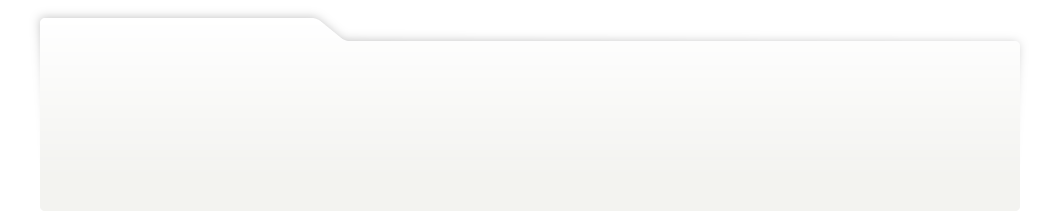
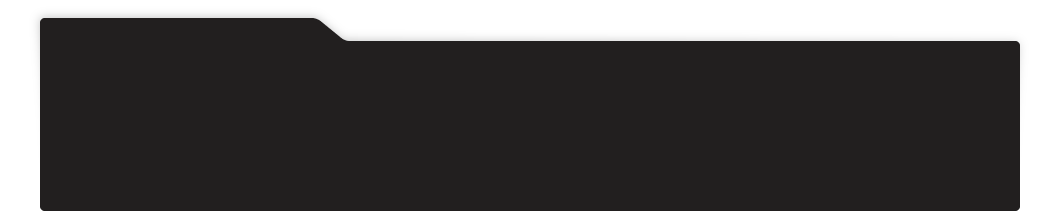
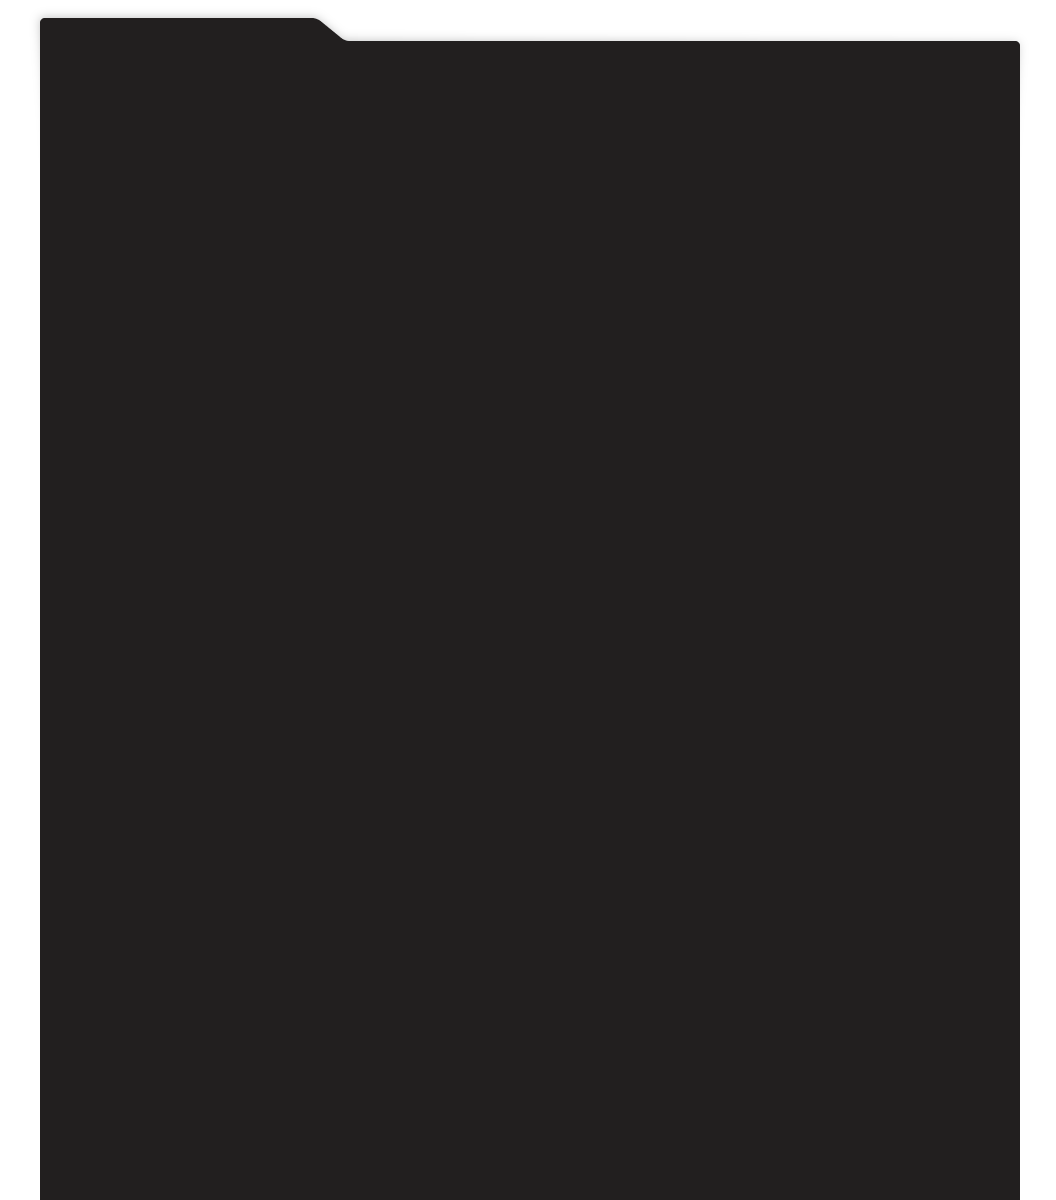
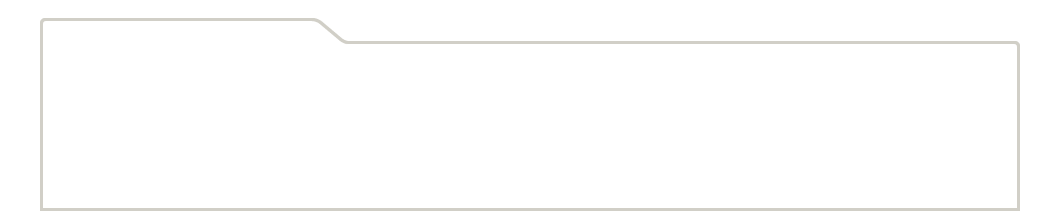
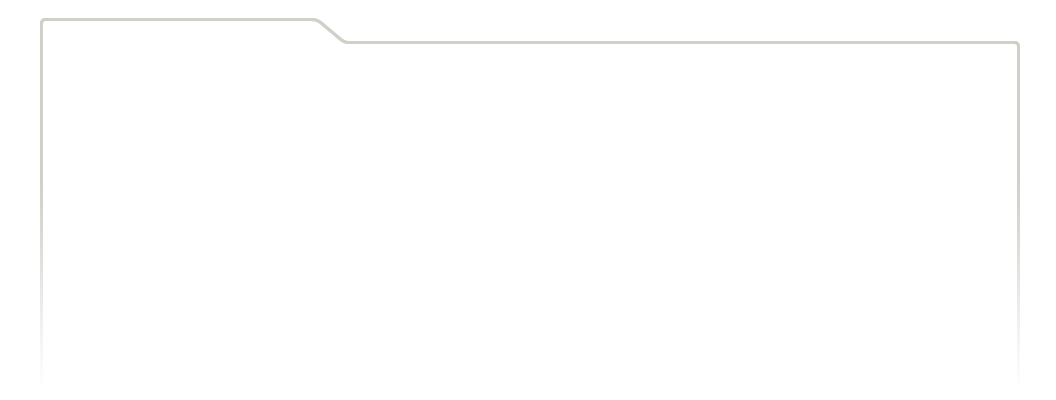
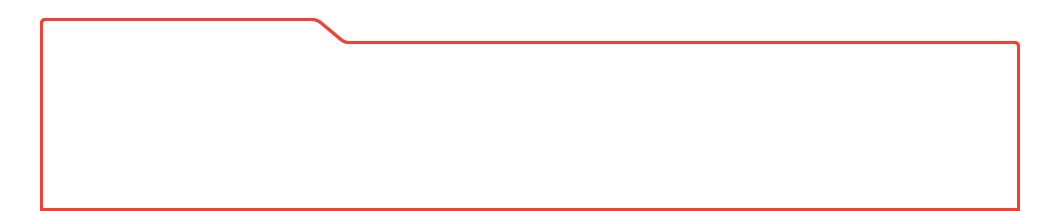
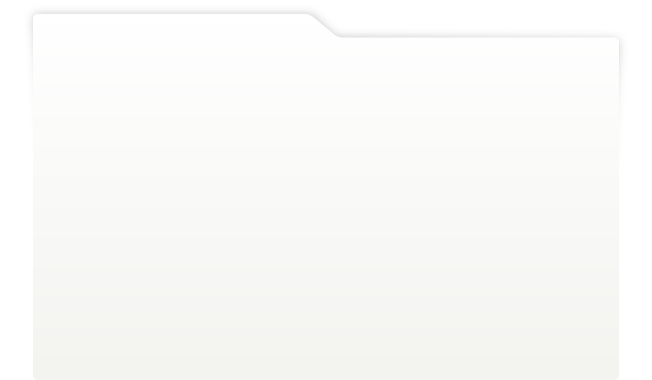
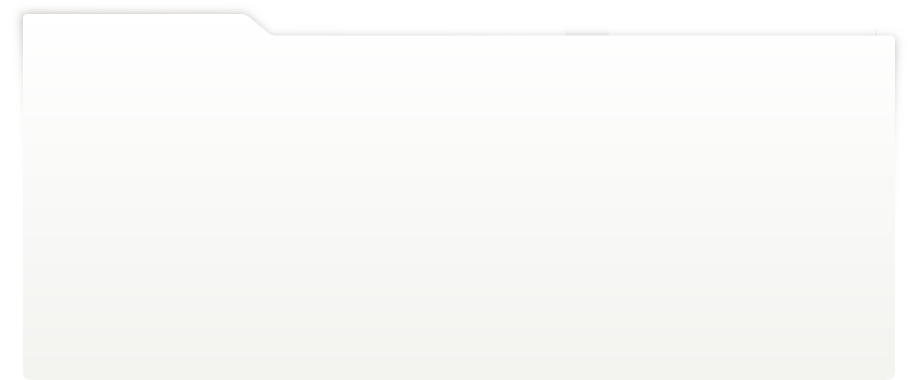
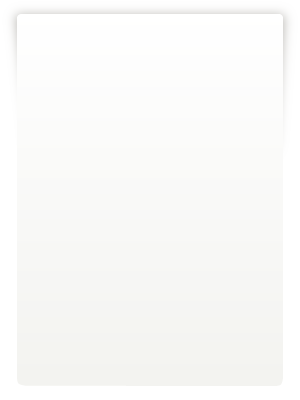
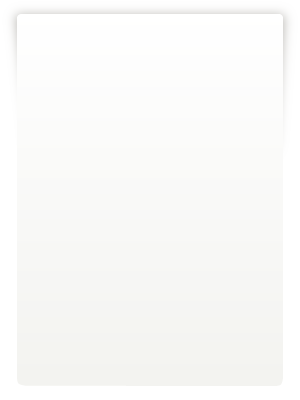
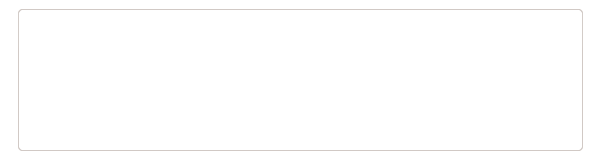
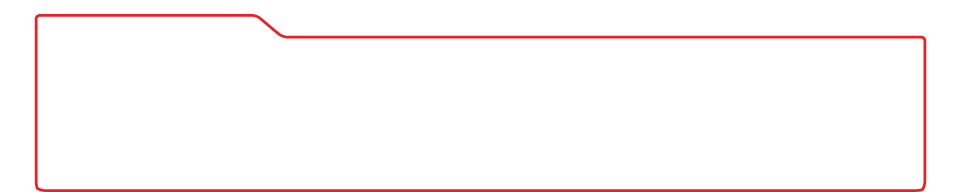
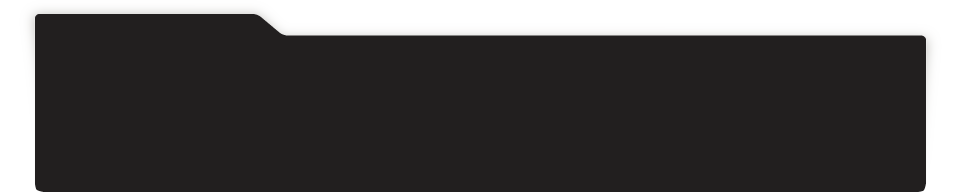
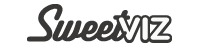
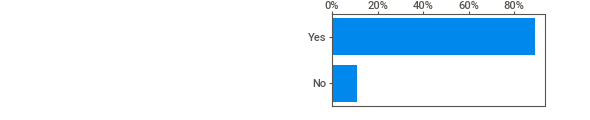
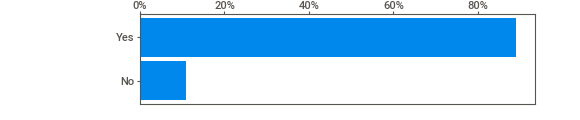
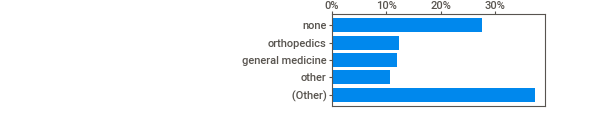
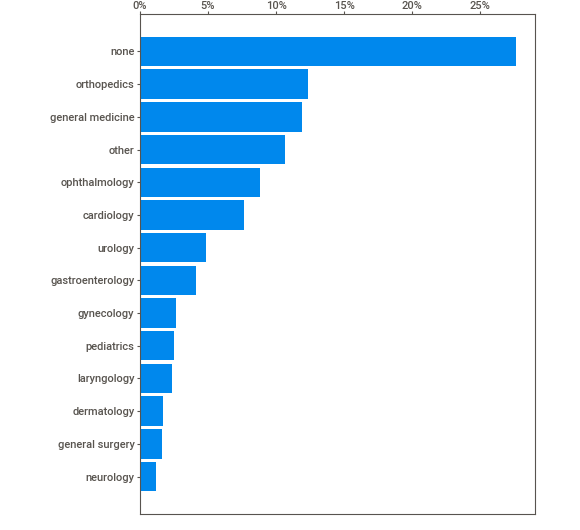
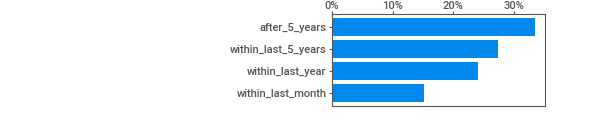
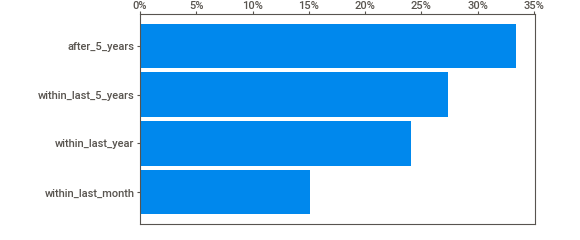
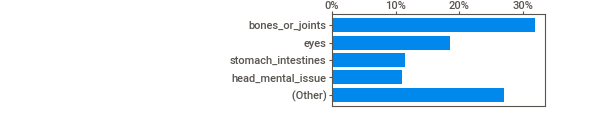
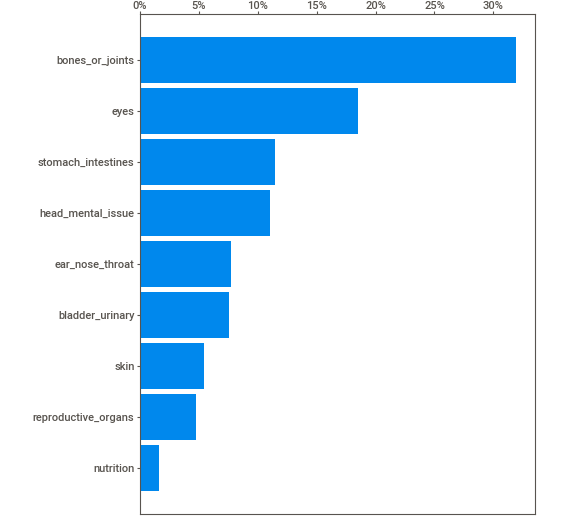
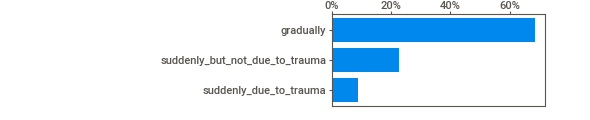
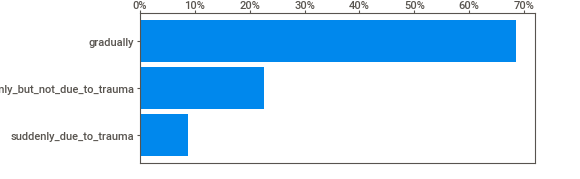
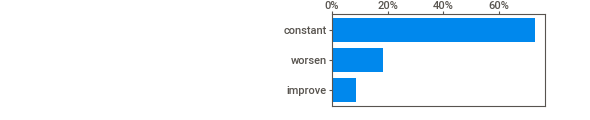
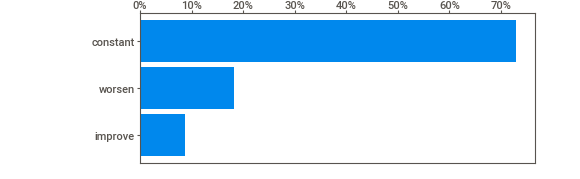
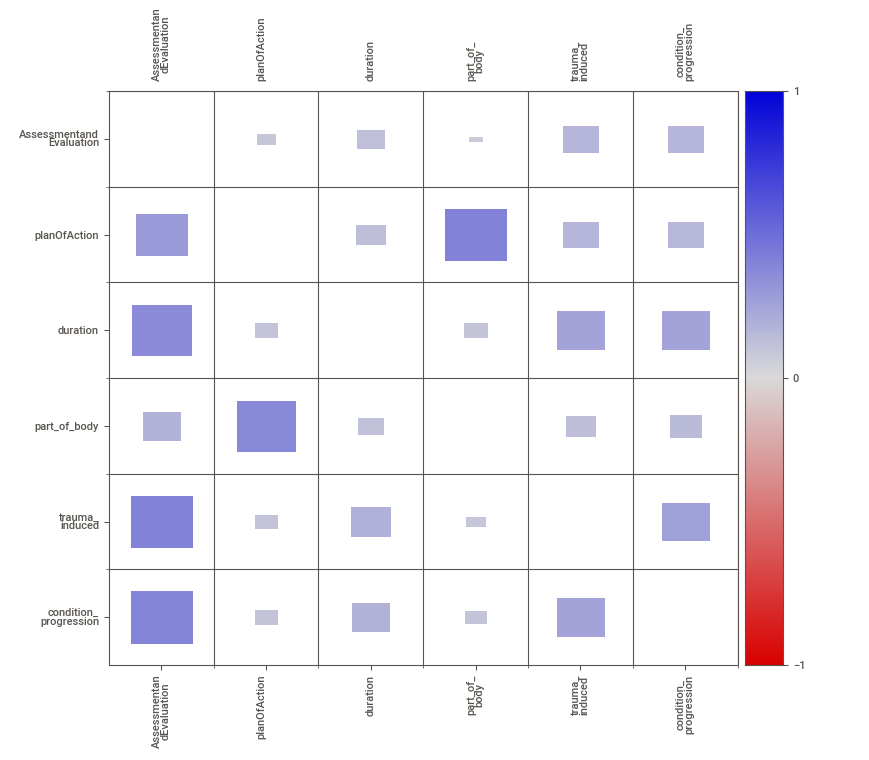
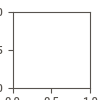

In [181]:
sv_report_eval_med = sv.analyze([eval_med, "Eval_med"])
sv_report_eval_med.show_notebook()

### 3. history_env

In [182]:
history_env.shape

(5472, 16)

In [183]:
history_env["numberofChildrenLivinginHouseUndertheAgeof5"] = history_env["numberofChildrenLivinginHouseUndertheAgeof5"].astype(str)

In [184]:
history_env.dtypes

objectId                                       object
yearsLivedinThisHouse                          object
waterAccess                                    object
typeofWaterdoyoudrink                          object
latrineAccess                                  object
conditionoFloorinyourhouse                     object
conditionoRoofinyourhouse                      object
medicalproblemswheredoyougo                    object
dentalproblemswheredoyougo                     object
biggestproblemofcommunity                      object
timesperweektrashcollected                     object
wheretrashleftbetweenpickups                   object
numberofIndividualsLivingintheHouse             int64
numberofChildrenLivinginHouseUndertheAgeof5    object
houseownership                                 object
bathroomAccess                                 object
dtype: object


In [185]:
history_env.isna().sum()

objectId                                          0
yearsLivedinThisHouse                            28
waterAccess                                     103
typeofWaterdoyoudrink                            54
latrineAccess                                  2228
conditionoFloorinyourhouse                      116
conditionoRoofinyourhouse                       139
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweektrashcollected                        0
wheretrashleftbetweenpickups                      0
numberofIndividualsLivingintheHouse               0
numberofChildrenLivinginHouseUndertheAgeof5       0
houseownership                                  219
bathroomAccess                                 2719
dtype: int64



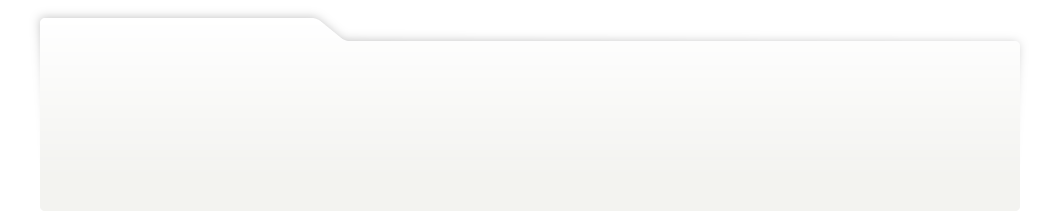
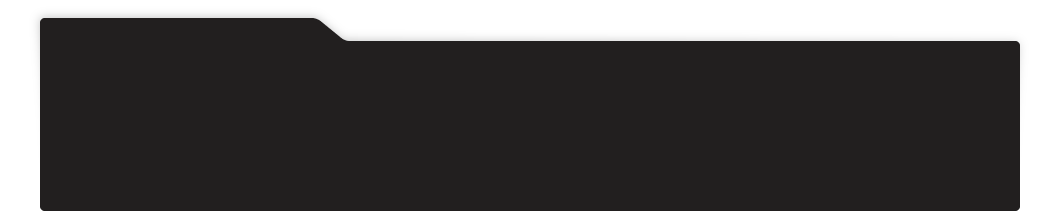
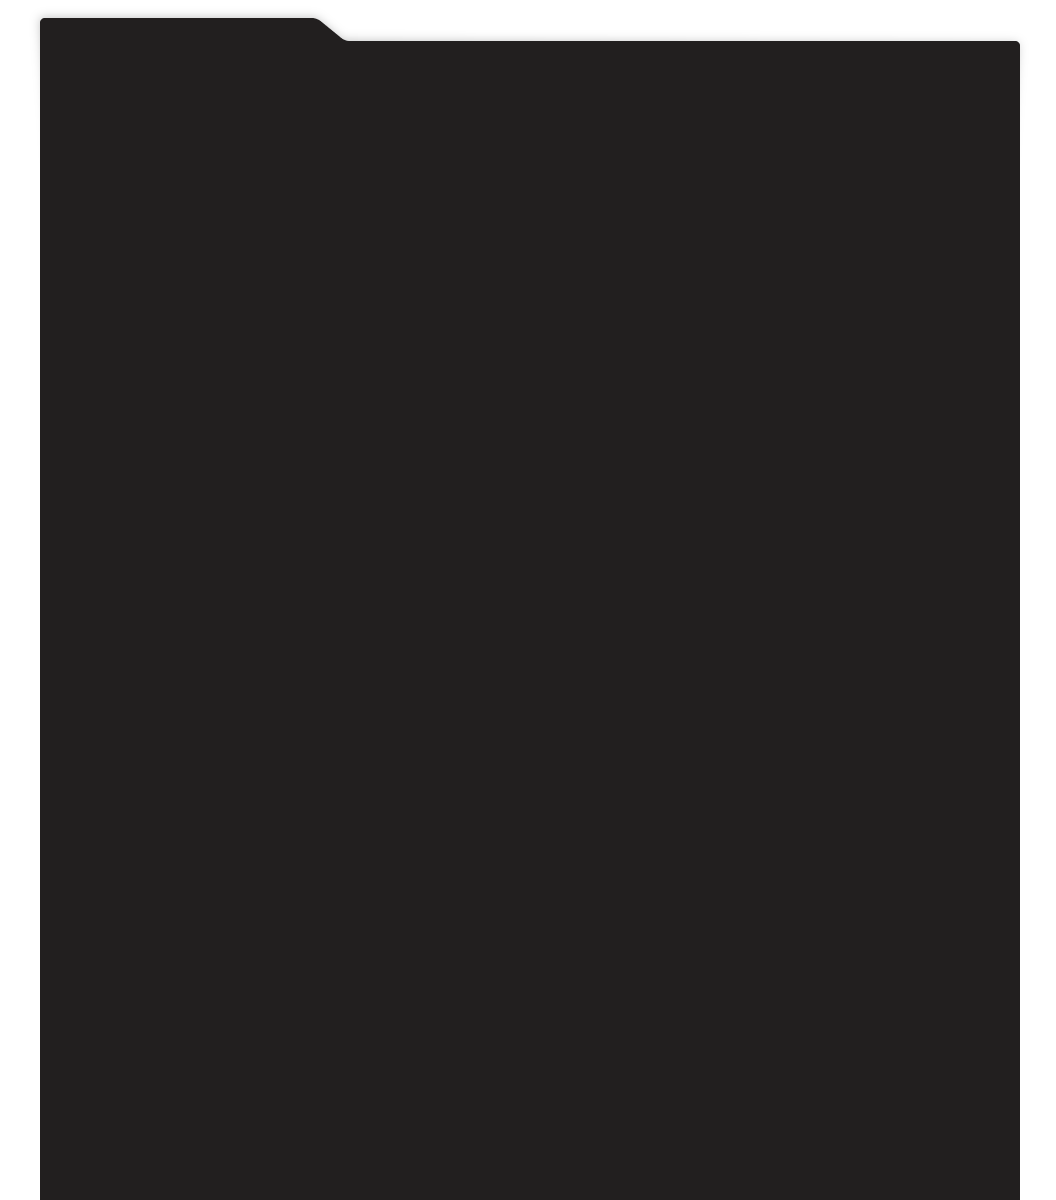
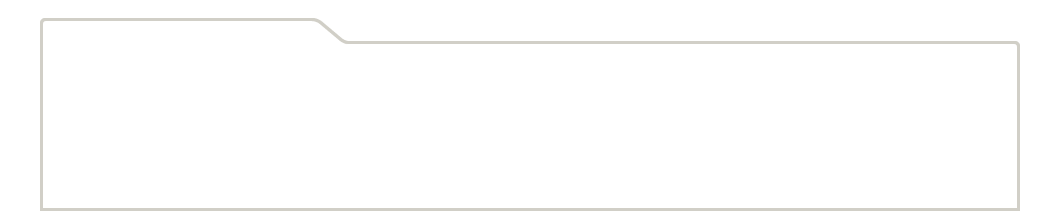
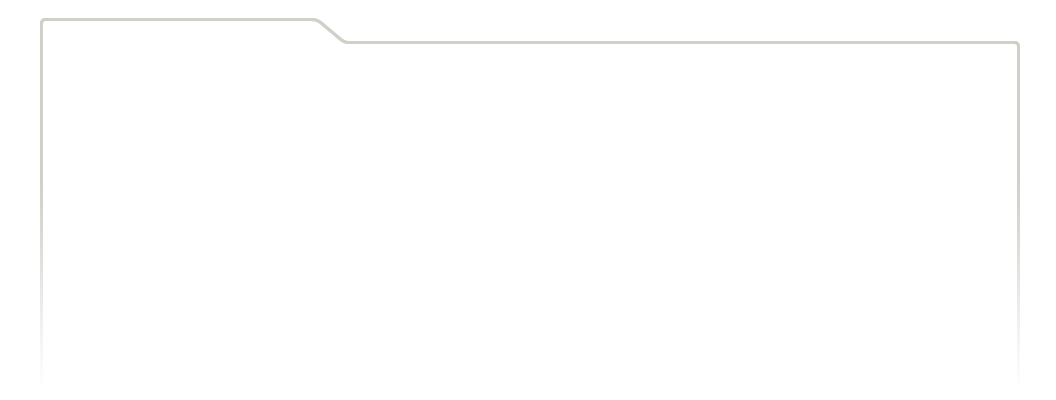
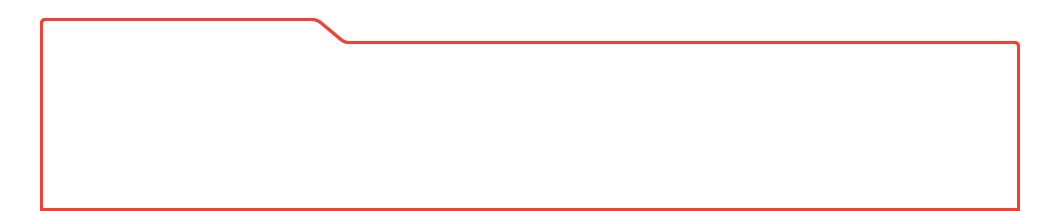
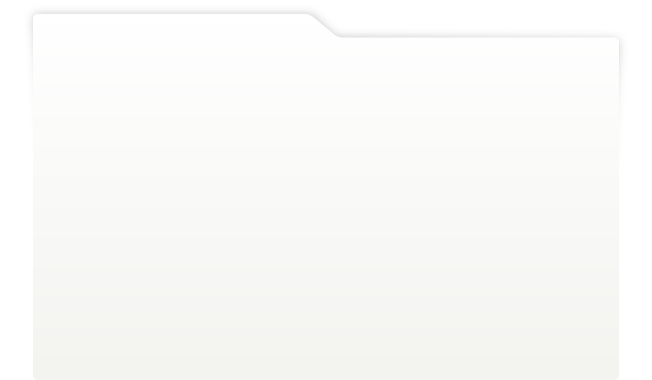
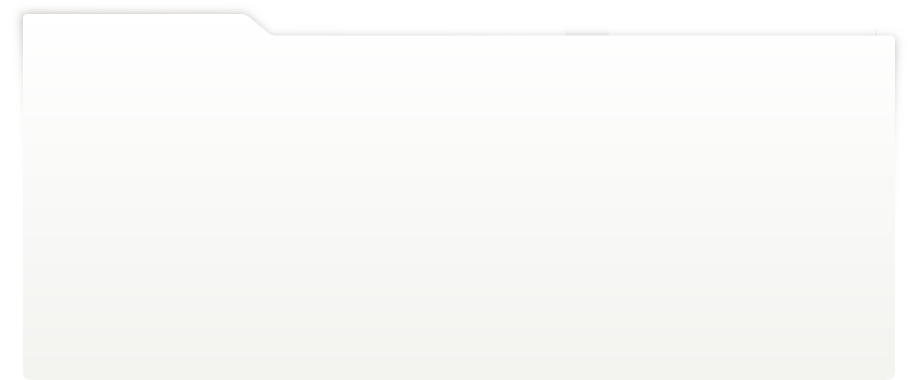
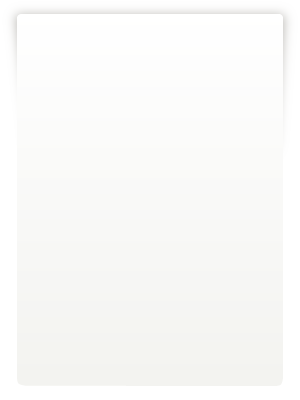
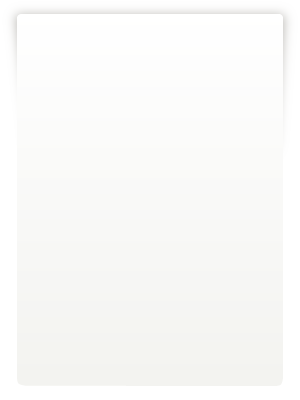
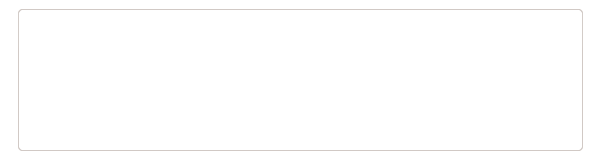
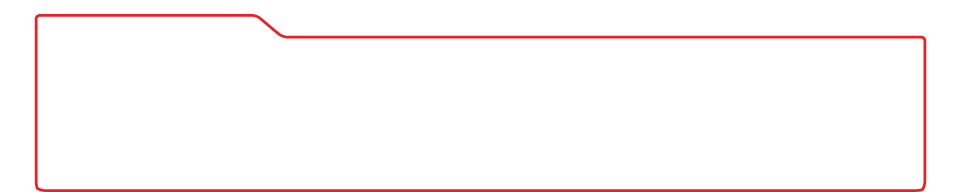
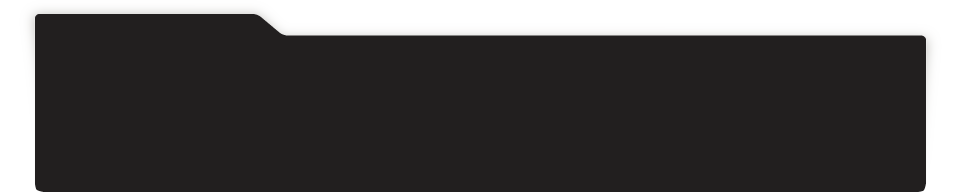
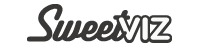
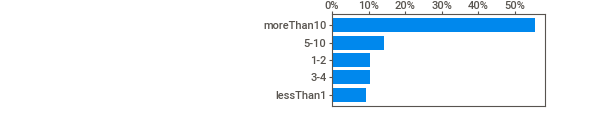
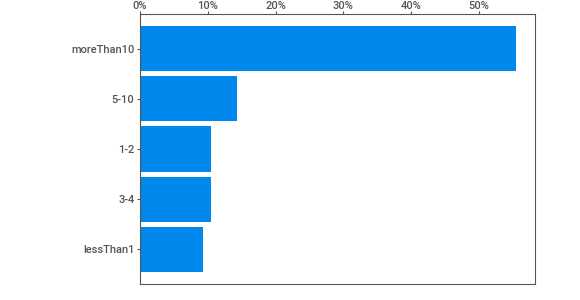
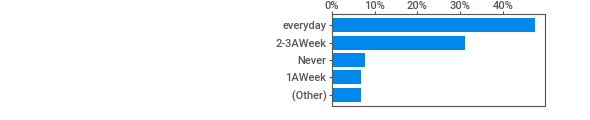
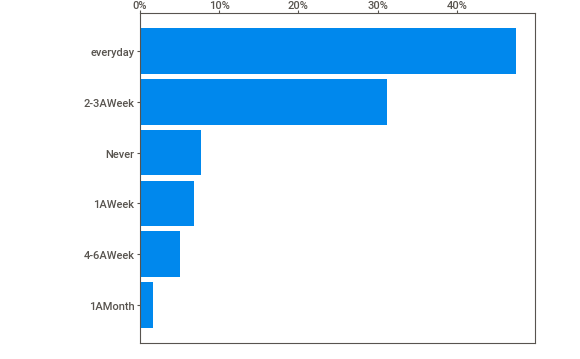
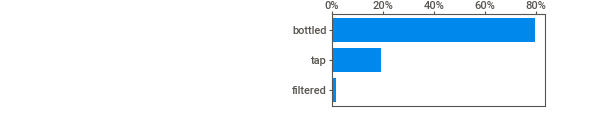
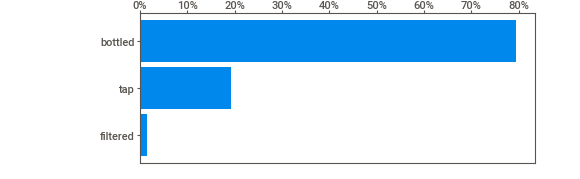
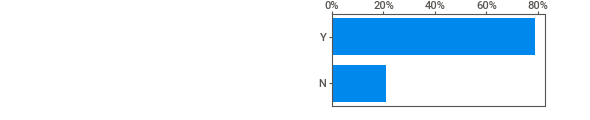
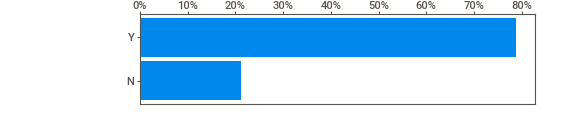
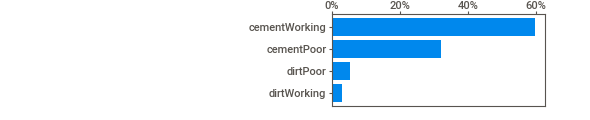
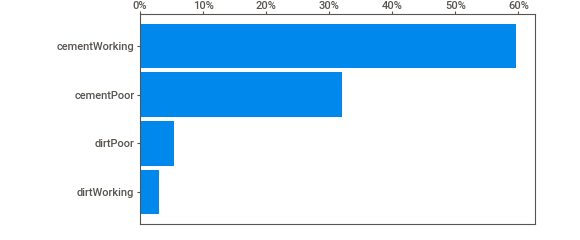
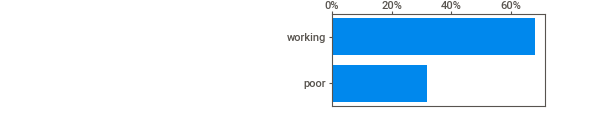
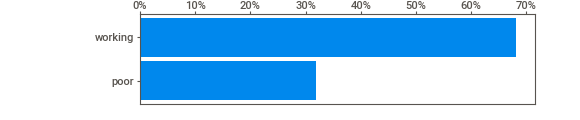
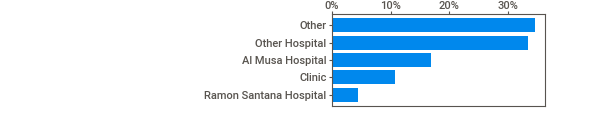
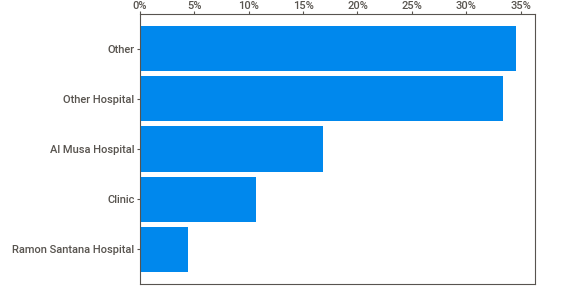
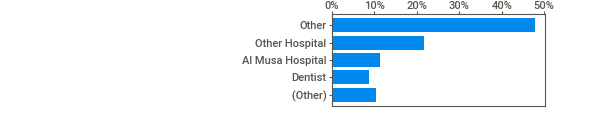
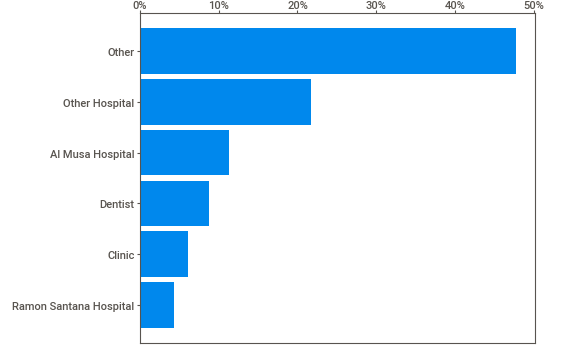
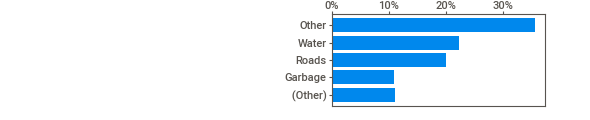
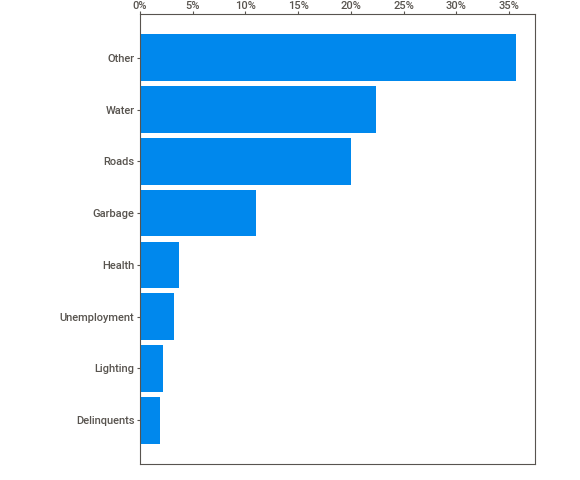
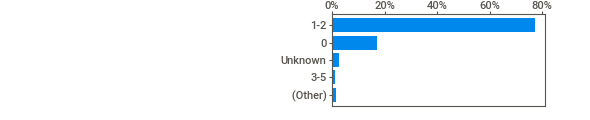
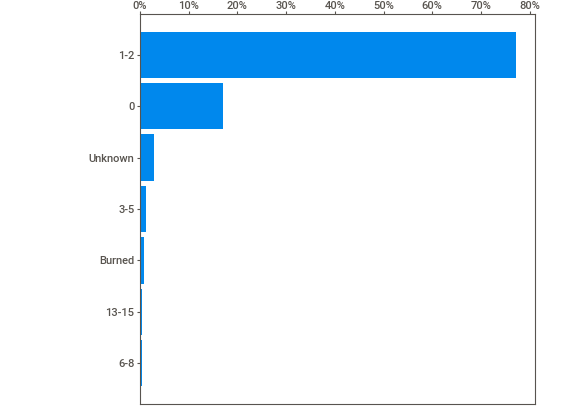
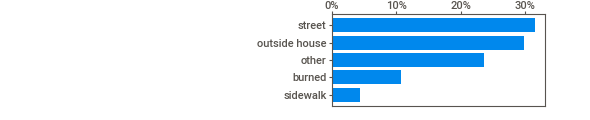
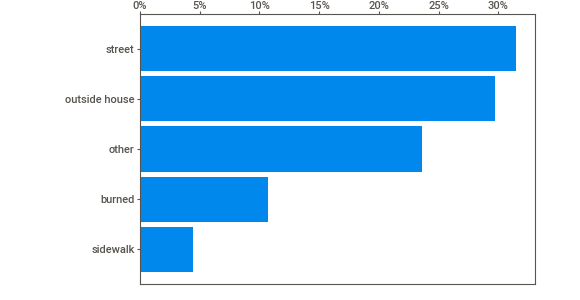
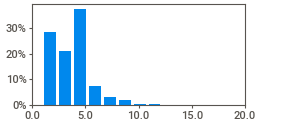
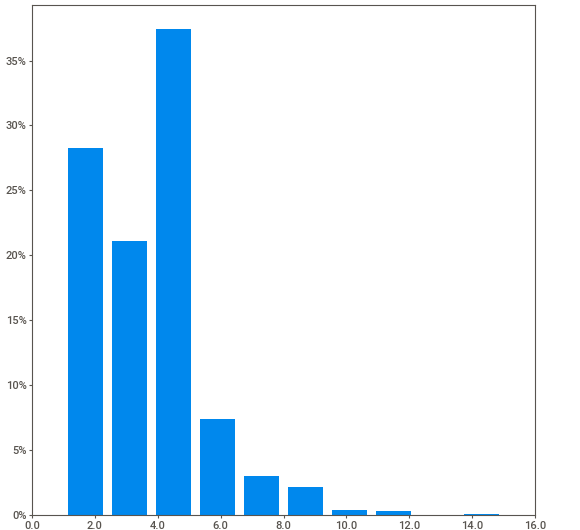
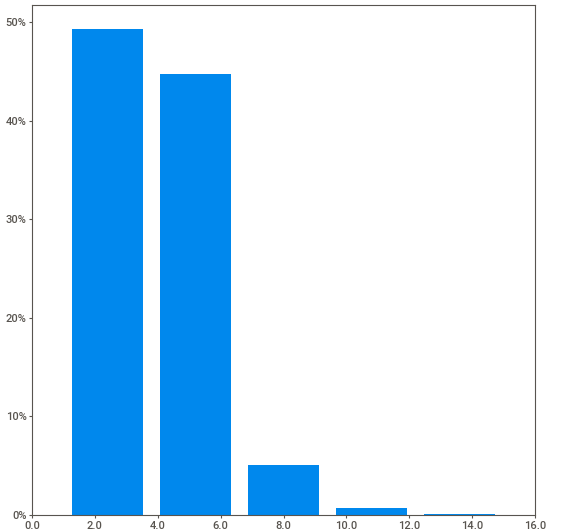
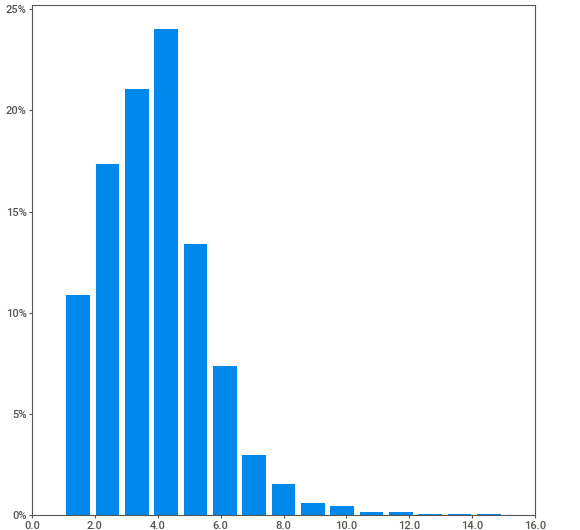
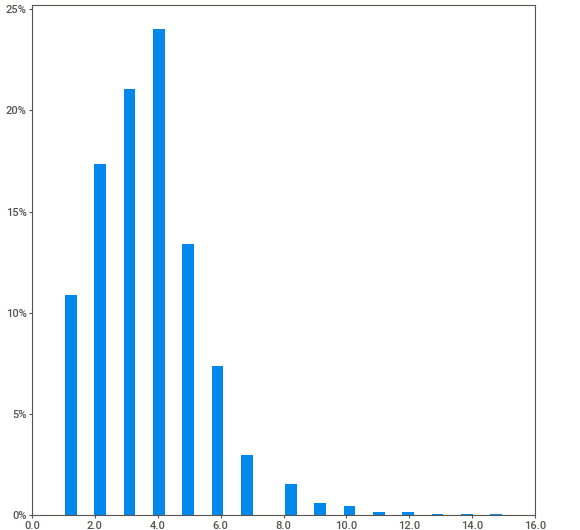
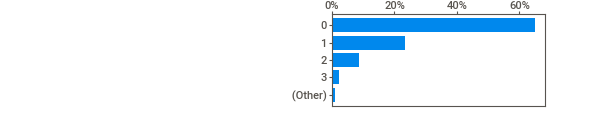
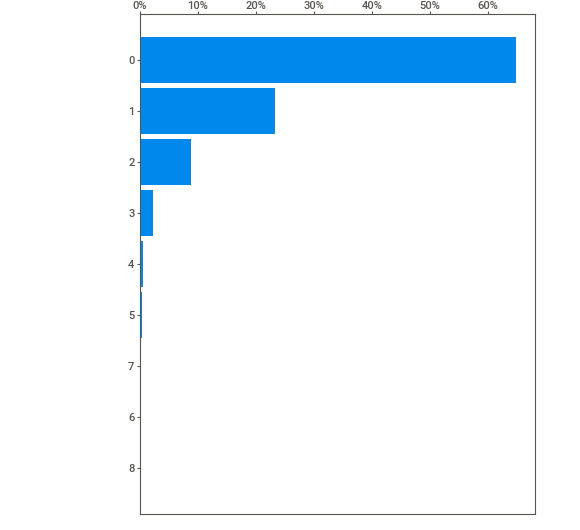
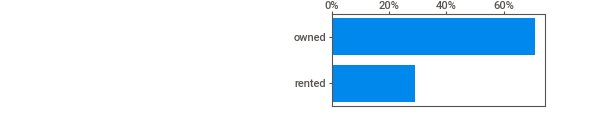
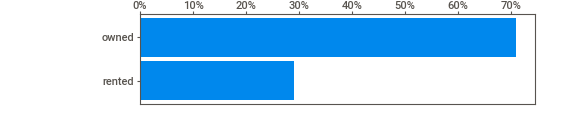
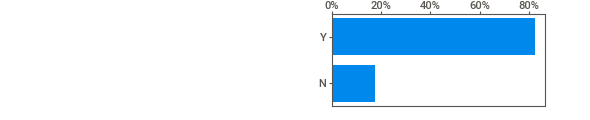
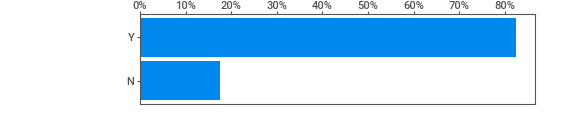
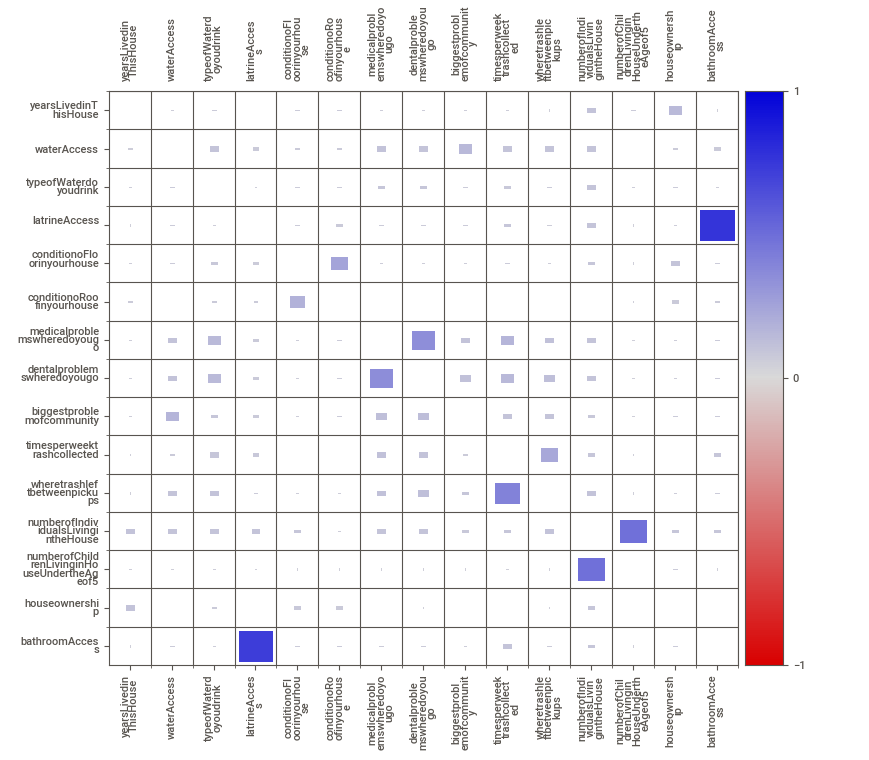
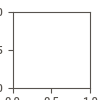

In [186]:
sv_report_history_env = sv.analyze([history_env, "History_env"])
sv_report_history_env.show_notebook()

# Mergings

### 1. History_env x survey_vitals

In [187]:
survey_environ = survey_vitals.merge(history_env, how = "inner", on = "objectId")
survey_environ.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  lLkC5HGPOC          widow  Ama de casa  lessThanprimary  18.914416   
1  gIoG2SAL99          widow        Other  lessThanprimary  18.914196   
2  GiArohoFUo        married        Other          college  18.910474   
3  rnNw8AxEix         single  Ama de casa          primary  18.910484   
4  YBLTPHNqsH      concubine        Other  lessThanprimary  18.915163   

   longitude   age     sex  clustersByLoc              province  ...  \
0 -70.745642  67.0  female              1  San Pedro de Macoris  ...   
1 -70.746286  80.0    male              1  San Pedro de Macoris  ...   
2 -70.747658  41.0  female              1  San Pedro de Macoris  ...   
3 -70.747650  40.0  female              1  San Pedro de Macoris  ...   
4 -70.741626  59.0    male              1  San Pedro de Macoris  ...   

  conditionoRoofinyourhouse medicalproblemswheredoyougo  \
0                   working              Other Hospital   
1                      poor              Other Hospital   
2                       NaN                       Other   
3                   working              Other Hospital   
4                   working                      Clinic   

  dentalproblemswheredoyougo biggestproblemofcommunity  \
0             Other Hospital                     Roads   
1                    Dentist                     Roads   
2                     Clinic                     Other   
3                      Other                     Water   
4                      Other                     Other   

  timesperweektrashcollected wheretrashleftbetweenpickups  \
0                        1-2                        other   
1                        1-2                        other   
2                        3-5                        other   
3                        1-2                        other   
4                        1-2                       street   

  numberofIndividualsLivingintheHouse  \
0                                   1   
1                                   5   
2                                   4   
3                                   4   
4                                   4   

  numberofChildrenLivinginHouseUndertheAgeof5 houseownership bathroomAccess  
0                                           0         rented            NaN  
1                                           0          owned            NaN  
2                                           0            NaN            NaN  
3                                           0            NaN            NaN  
4                                           0            NaN            NaN  

[5 rows x 25 columns]

In [188]:
survey_environ.shape

(5423, 25)

In [189]:
survey_environ.isna().sum()

objectId                                          0
marriageStatus                                    0
occupation                                        0
educationLevel                                    0
latitude                                          0
longitude                                         0
age                                               0
sex                                               0
clustersByLoc                                     0
province                                          0
yearsLivedinThisHouse                            17
waterAccess                                      84
typeofWaterdoyoudrink                            40
latrineAccess                                  2208
conditionoFloorinyourhouse                       98
conditionoRoofinyourhouse                       119
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweek

In [191]:
survey_vitals.province.value_counts()

Lavega                        4688
San Pedro de Macoris          4044
San Pedro de Macoris/North     498
Santiago                       228
Name: province, dtype: int64


In [194]:
def by_province(feature, df):
    la_vega = df[df["province"] == "Lavega"]
    san = df[df["province"] == "Santiago"]
    san_pedro = df[df["province"] == "San Pedro de Macoris"]
    san_pedro_n = df[df["province"] == "San Pedro de Macoris/North"]
    order = list(df[feature].value_counts().index)
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    fig.set_size_inches(25,25)
    fig.tight_layout(pad=7.0)
    ax1 = sns.countplot(x = feature, order = order ,data = la_vega, ax = ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), 
                              rotation=30, 
                              horizontalalignment='right')
    ax1.set_title("Distribution of " + feature + " Types in Lavega")
    ax2 = sns.countplot(x = feature, order = order, data = san, ax = ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), 
                          rotation=30, 
                          horizontalalignment='right')
    ax2.set_title("Distribution of " + feature + " Types in Santiago")
    ax3 = sns.countplot(x = feature, order = order,data = san_pedro, ax = ax3)
    ax3.set_xticklabels(ax3.get_xticklabels(), 
                          rotation=30, 
                          horizontalalignment='right')
    ax3.set_title("Distribution of " + feature + " Types in San Pedro de Macoris")
    ax4 = sns.countplot(x = feature, order = order,data = san_pedro_n, ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(), 
                          rotation=30, 
                          horizontalalignment='right')
    ax4.set_title("Distribution of " + feature + " Types in San Pedro de Macoris/North")

808        Never
809        Never
810        Never
953          NaN
954     4-6AWeek
955          NaN
1135    everyday
3024    2-3AWeek
3025    everyday
4552    everyday
4557    everyday
4558    everyday
4560    everyday
4562    everyday
4564    everyday
4565    everyday
4566    everyday
4567    everyday
4569    4-6AWeek
4829    everyday
4830    4-6AWeek
4831    4-6AWeek
4832    everyday
4833    4-6AWeek
4834    everyday
4835    everyday
4836    4-6AWeek
4841    everyday
4842    everyday
4843    everyday
4844    4-6AWeek
4845    everyday
4872    everyday
4873    everyday
Name: waterAccess, dtype: object


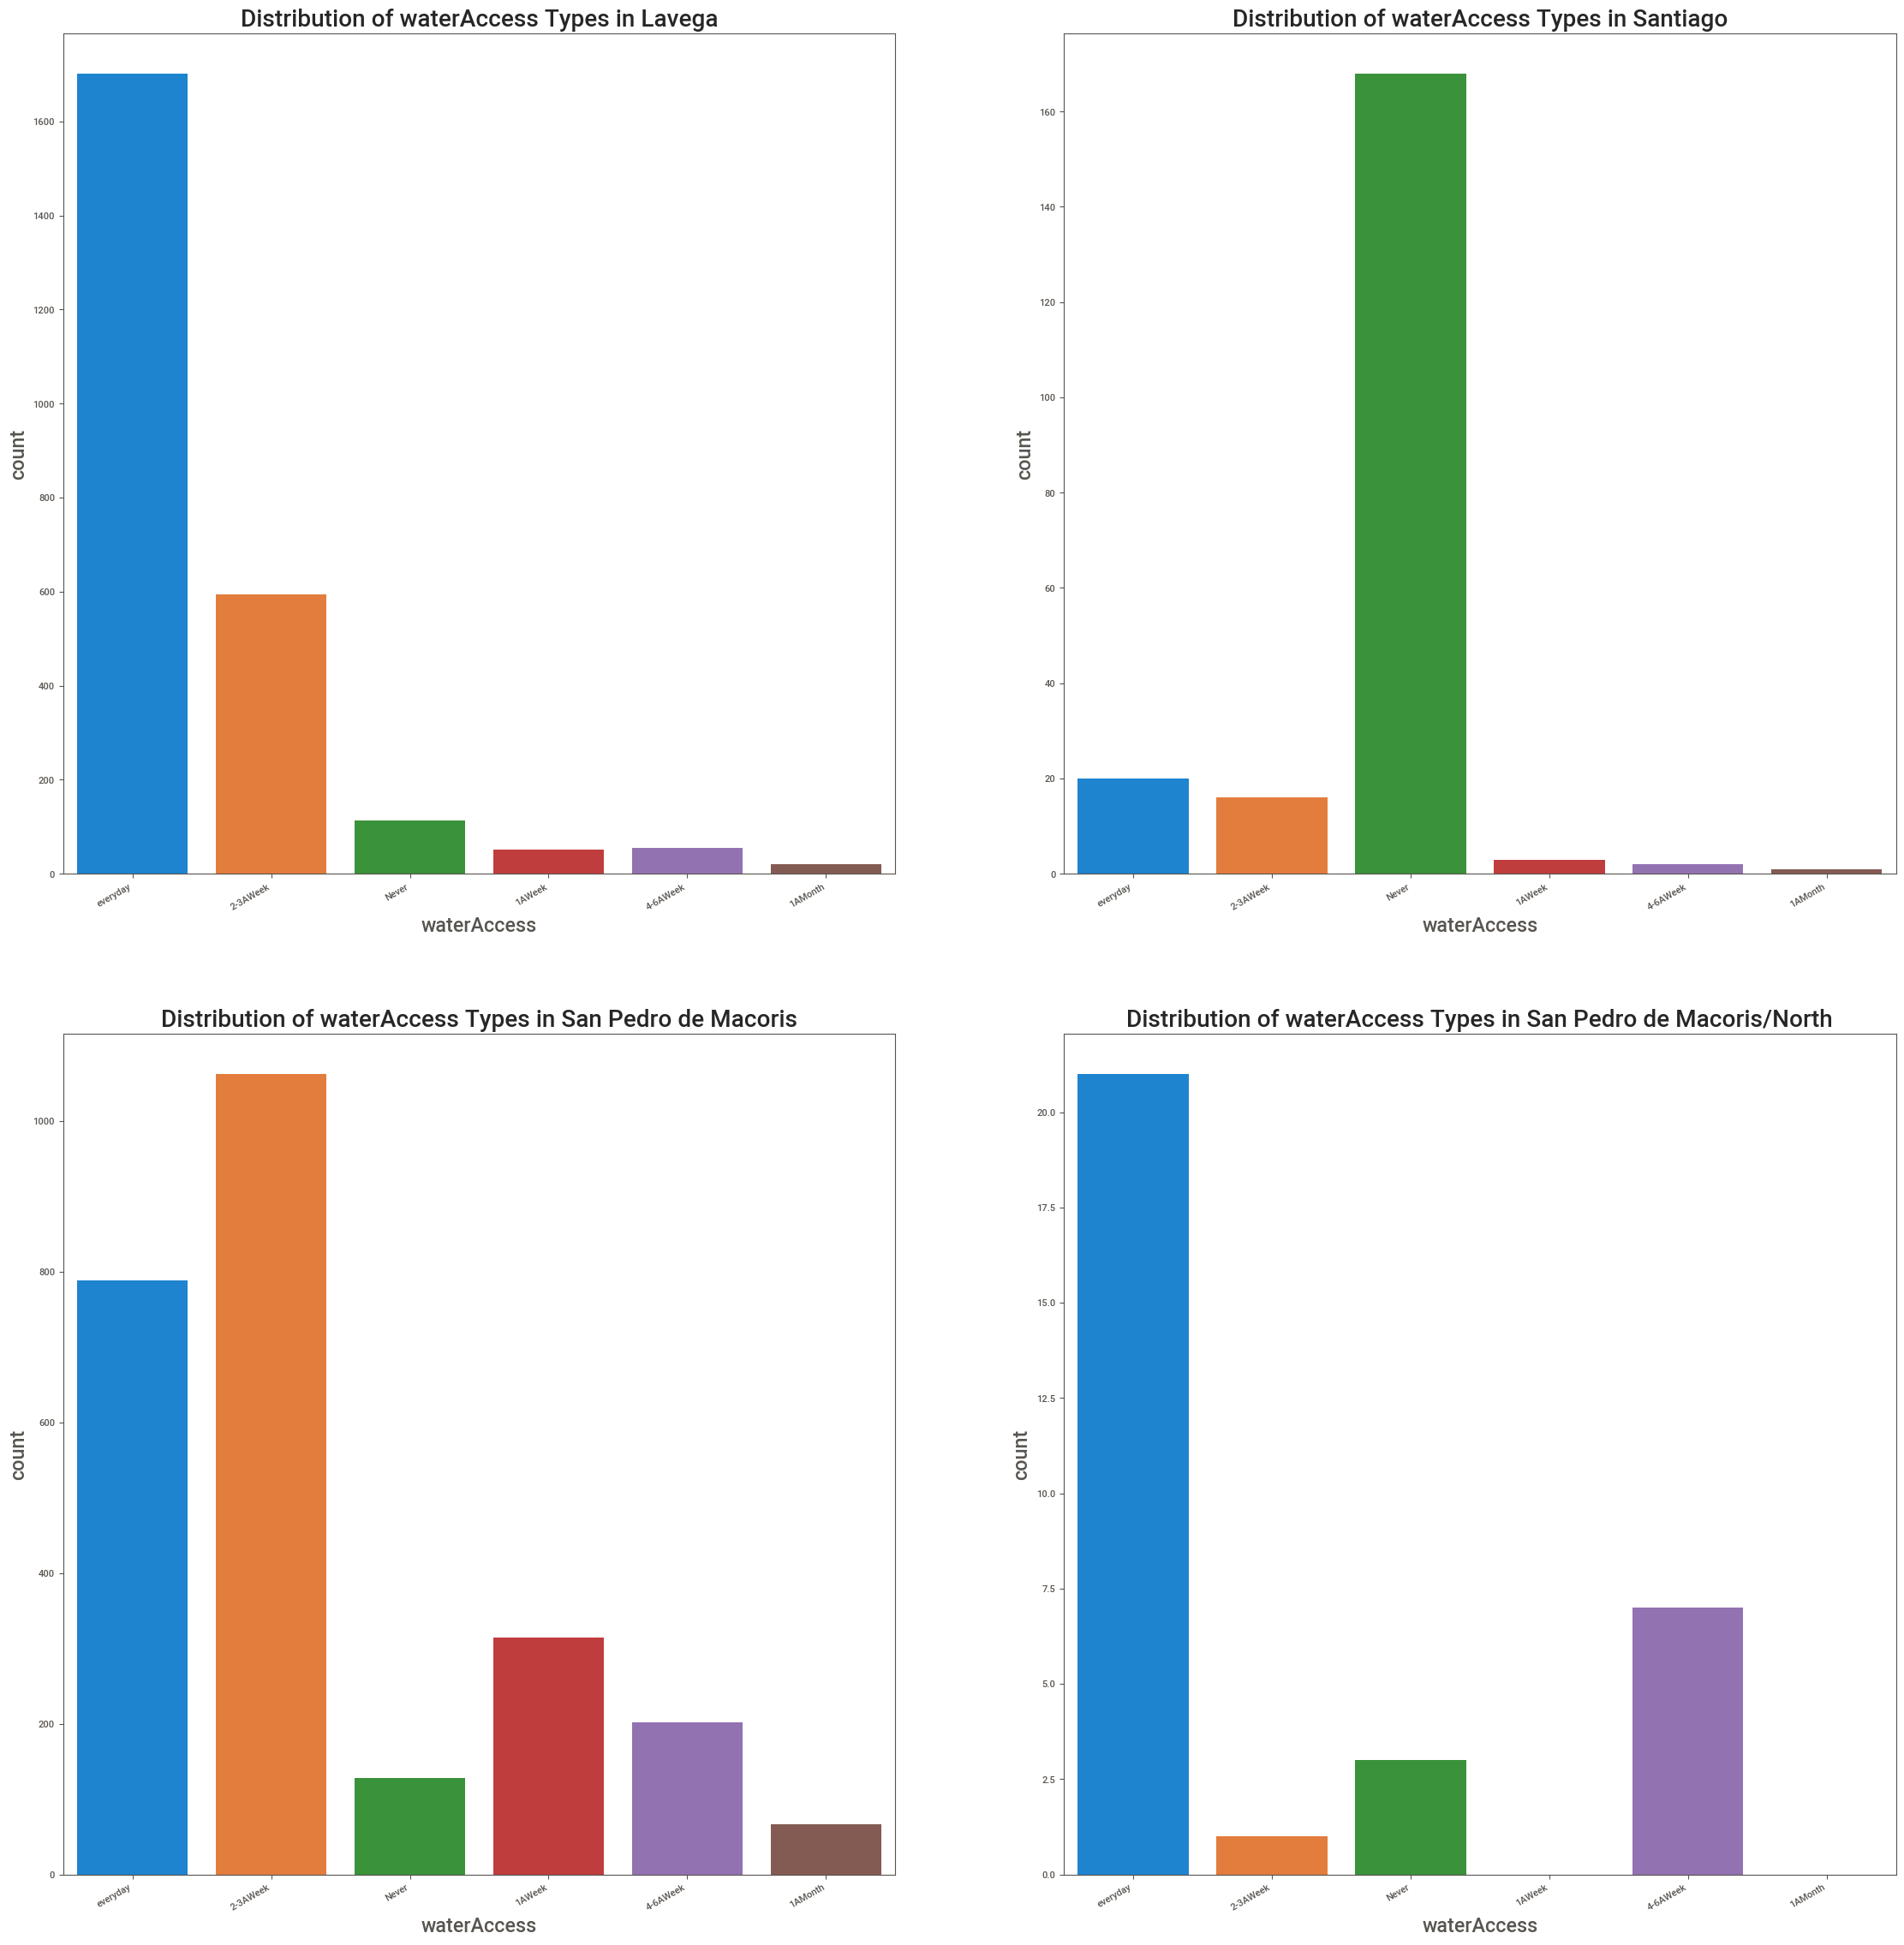

In [195]:
by_province("waterAccess", survey_environ)

808         tap
809         NaN
810         NaN
953         tap
954         tap
955         NaN
1135    bottled
3024    bottled
3025    bottled
4552    bottled
4557    bottled
4558    bottled
4560    bottled
4562    bottled
4564    bottled
4565    bottled
4566    bottled
4567    bottled
4569    bottled
4829    bottled
4830    bottled
4831    bottled
4832    bottled
4833    bottled
4834    bottled
4835    bottled
4836    bottled
4841    bottled
4842    bottled
4843    bottled
4844    bottled
4845    bottled
4872    bottled
4873    bottled
Name: typeofWaterdoyoudrink, dtype: object


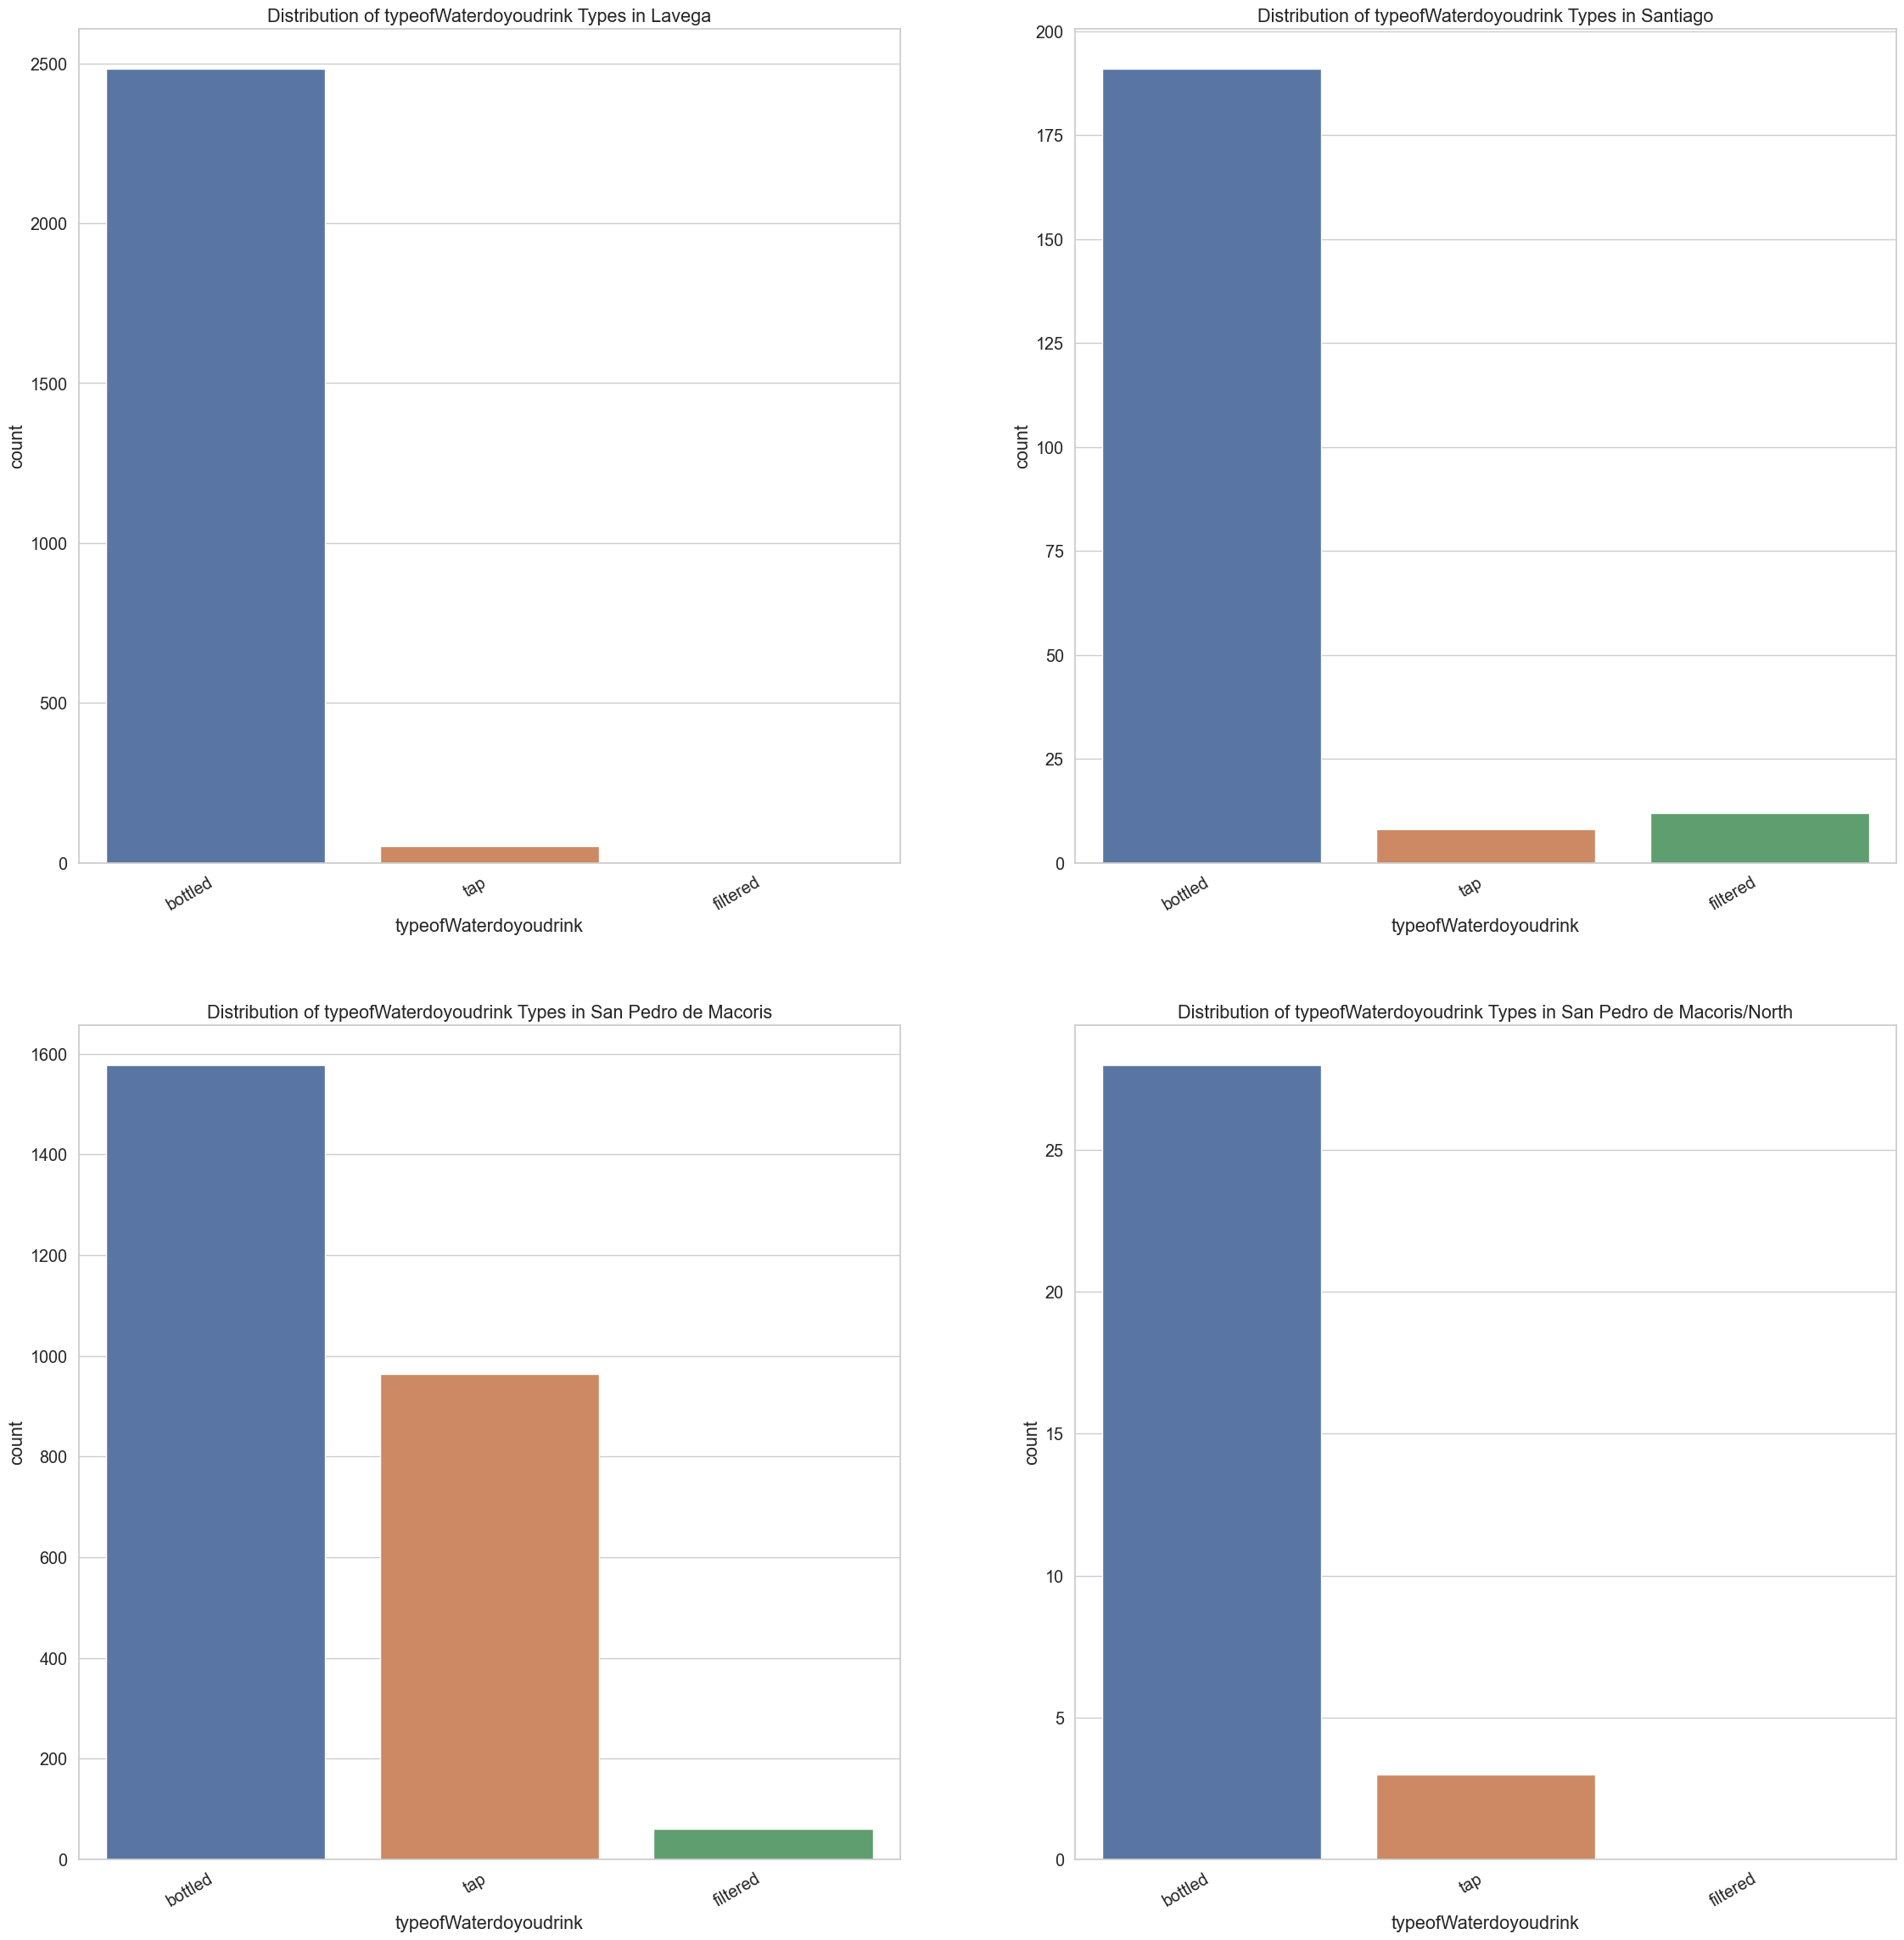

In [199]:
by_province("typeofWaterdoyoudrink", survey_environ)

### 2. Survey_vitals x eval_med

In [201]:
survey_med = survey_vitals.merge(eval_med, how = "inner", on = "objectId")
survey_med.head()

objectId marriageStatus   occupation   educationLevel   latitude  \
0  8BAdCPGEE1      concubine        Other  lessThanprimary  18.912805   
1  8BAdCPGEE1      concubine        Other  lessThanprimary  18.912805   
2  bWCqNwtKYL      concubine  Ama de casa  lessThanprimary  18.912537   
3  bWCqNwtKYL      concubine  Ama de casa  lessThanprimary  18.912537   
4  056xDPGU2U      concubine        Other  lessThanprimary  18.912727   

   longitude   age     sex  clustersByLoc              province  \
0 -70.744914  73.0    male              1  San Pedro de Macoris   
1 -70.744914  73.0    male              1  San Pedro de Macoris   
2 -70.744927  65.0  female              1  San Pedro de Macoris   
3 -70.744927  65.0  female              1  San Pedro de Macoris   
4 -70.745074  79.0    male              1  San Pedro de Macoris   

  AssessmentandEvaluation planOfAction duration part_of_body trauma_induced  \
0                     Yes         none      NaN          NaN            NaN   
1                     Yes        other      NaN          NaN            NaN   
2                      No         none      NaN          NaN            NaN   
3                     Yes        other      NaN          NaN            NaN   
4                      No         none      NaN          NaN            NaN   

  condition_progression  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [202]:
len(survey_med[survey_med["province"] == "La Vega"])

0

In [203]:
survey_med.isna().sum()

objectId                      0
marriageStatus                0
occupation                    0
educationLevel                0
latitude                      0
longitude                     0
age                           0
sex                           0
clustersByLoc                 0
province                      0
AssessmentandEvaluation       0
planOfAction                  0
duration                    645
part_of_body               1439
trauma_induced              746
condition_progression       771
dtype: int64


105                   skin
106                    NaN
107                    NaN
108                    NaN
109                    NaN
               ...        
7974       bones_or_joints
7975    stomach_intestines
7976                  eyes
7977                   NaN
7978                   NaN
Name: part_of_body, Length: 125, dtype: object


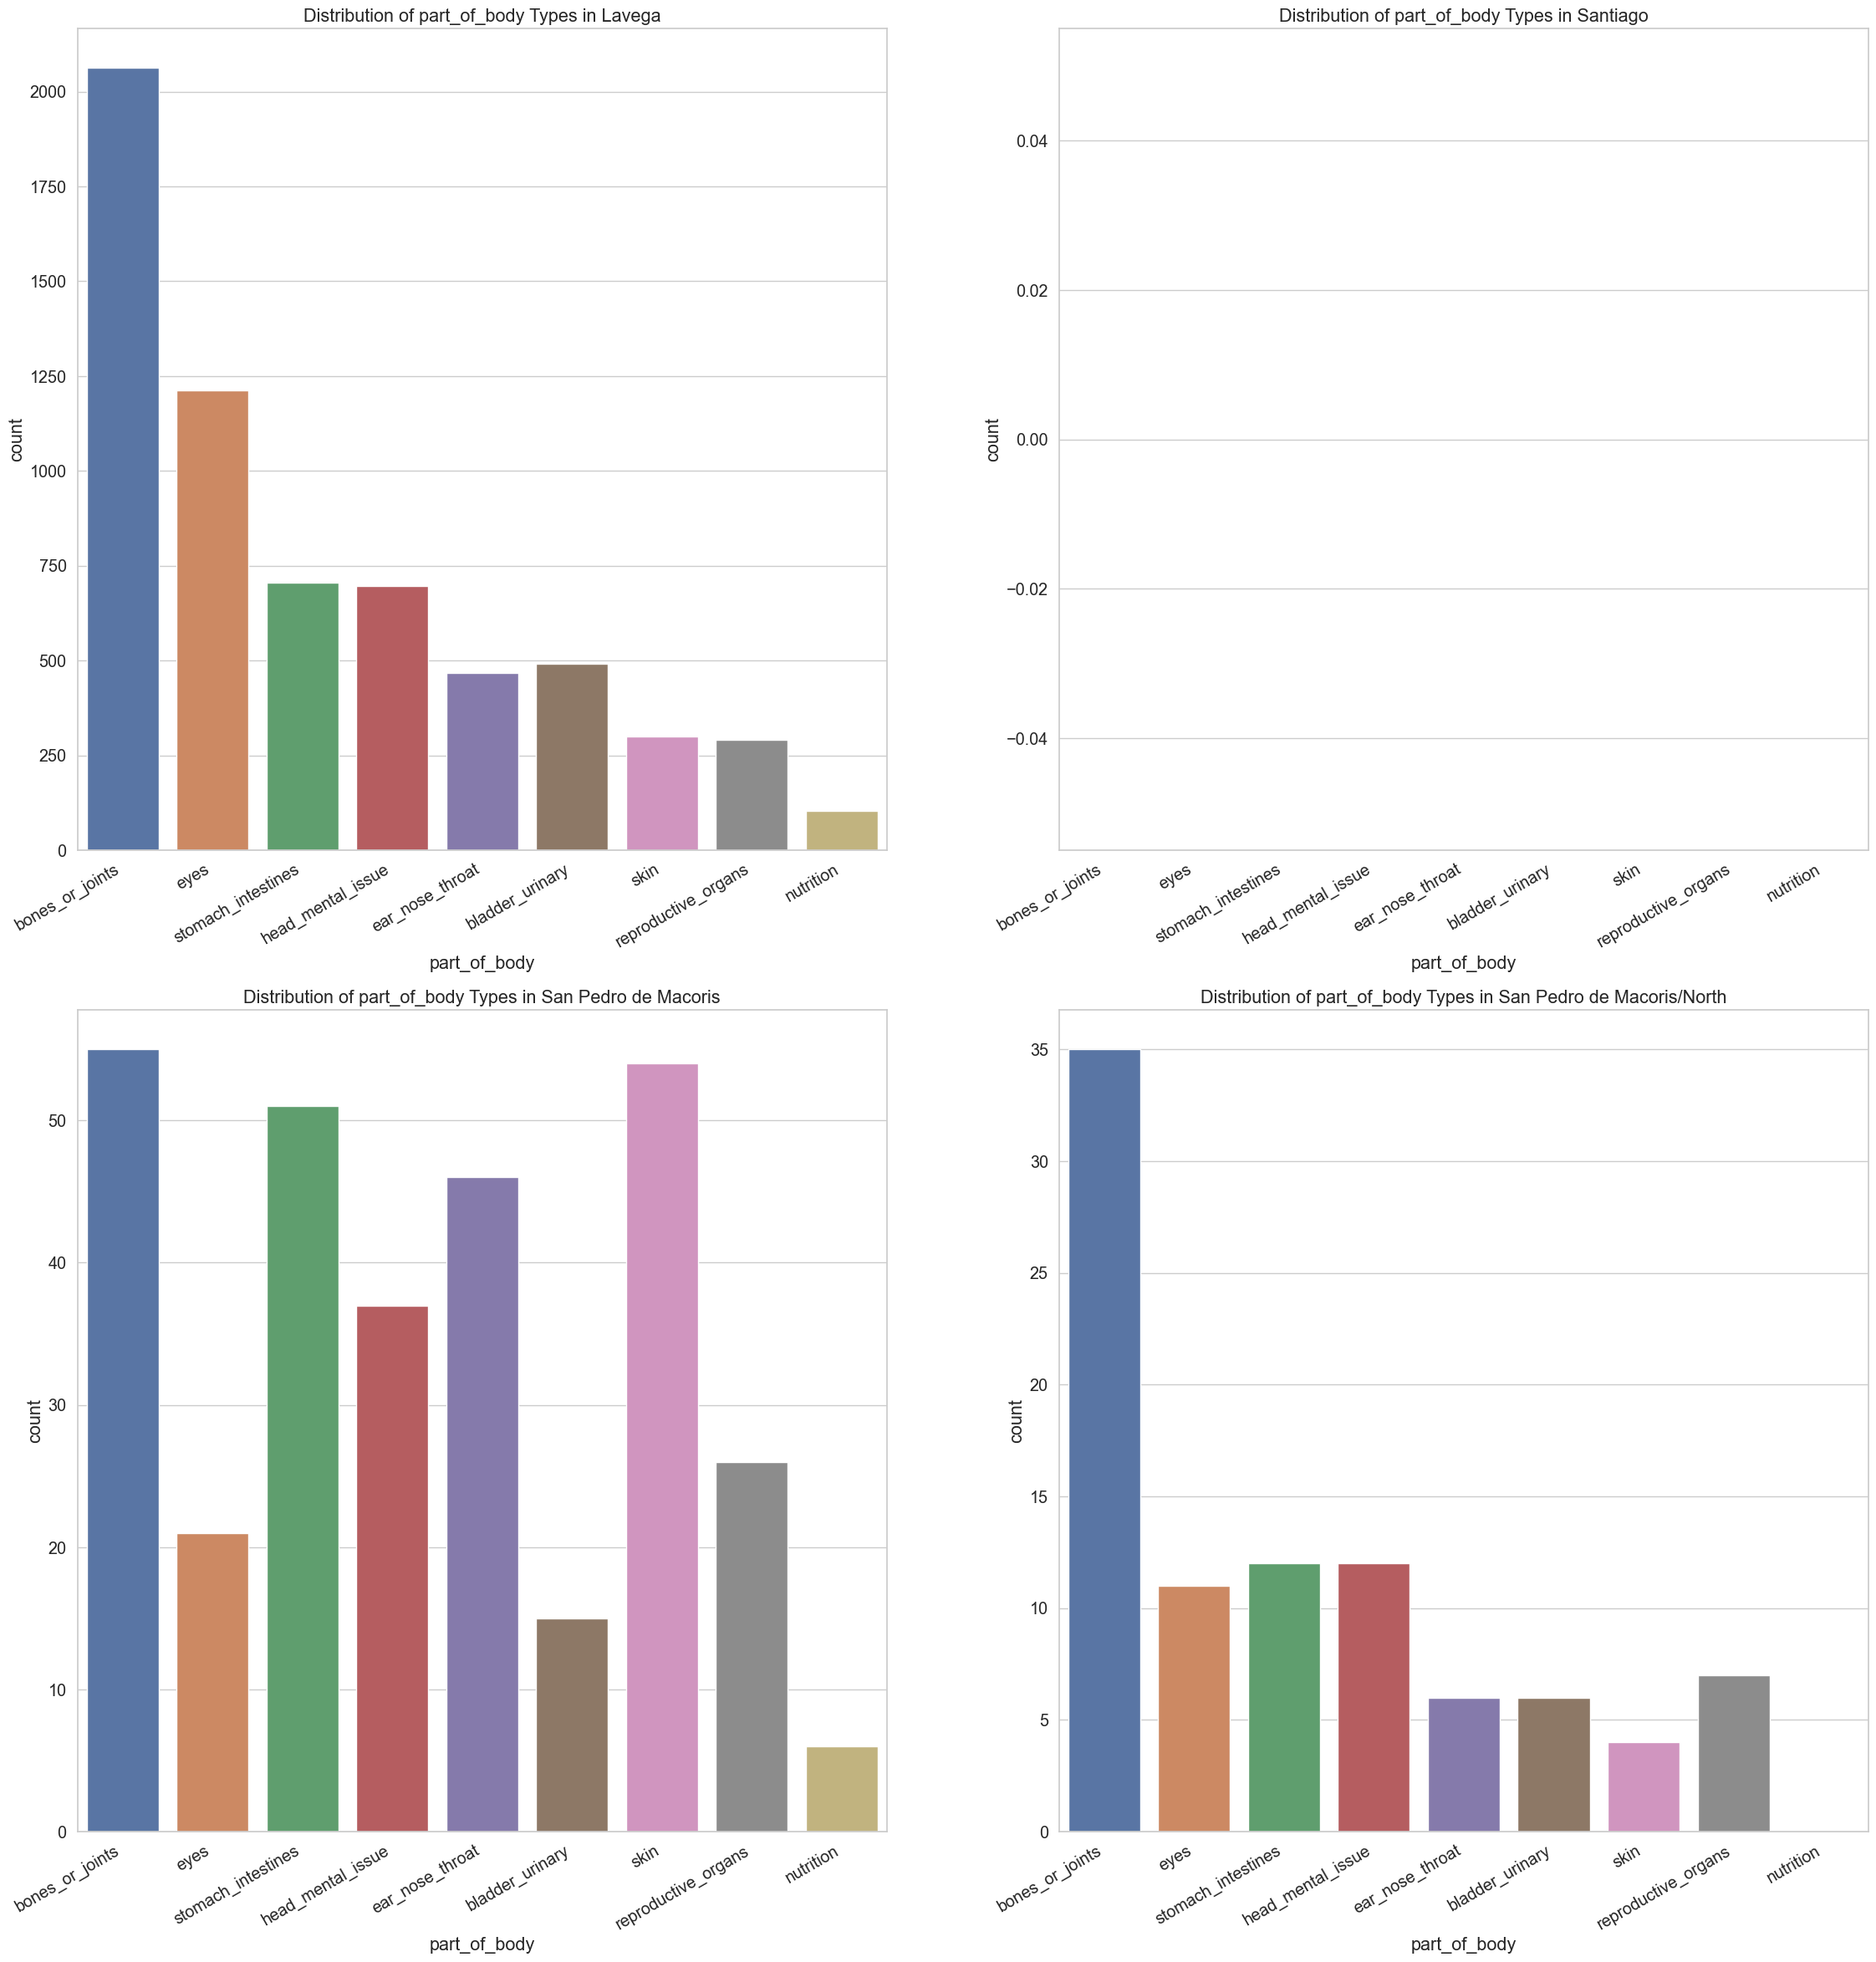

In [204]:
by_province("part_of_body", survey_med)

In [206]:
survey_med.province.value_counts()

Lavega                        7480
San Pedro de Macoris           565
San Pedro de Macoris/North     125
Santiago                         1
Name: province, dtype: int64



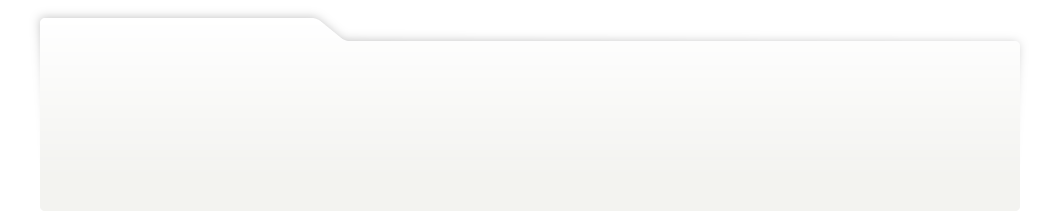
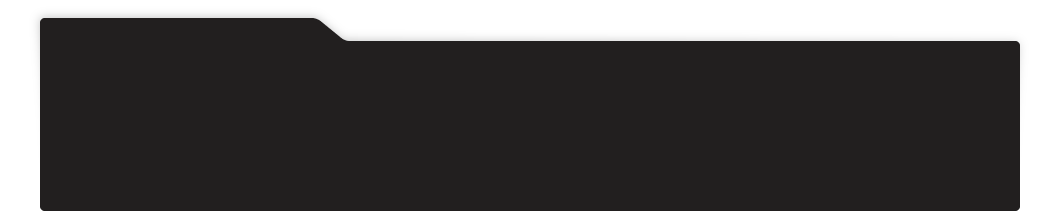
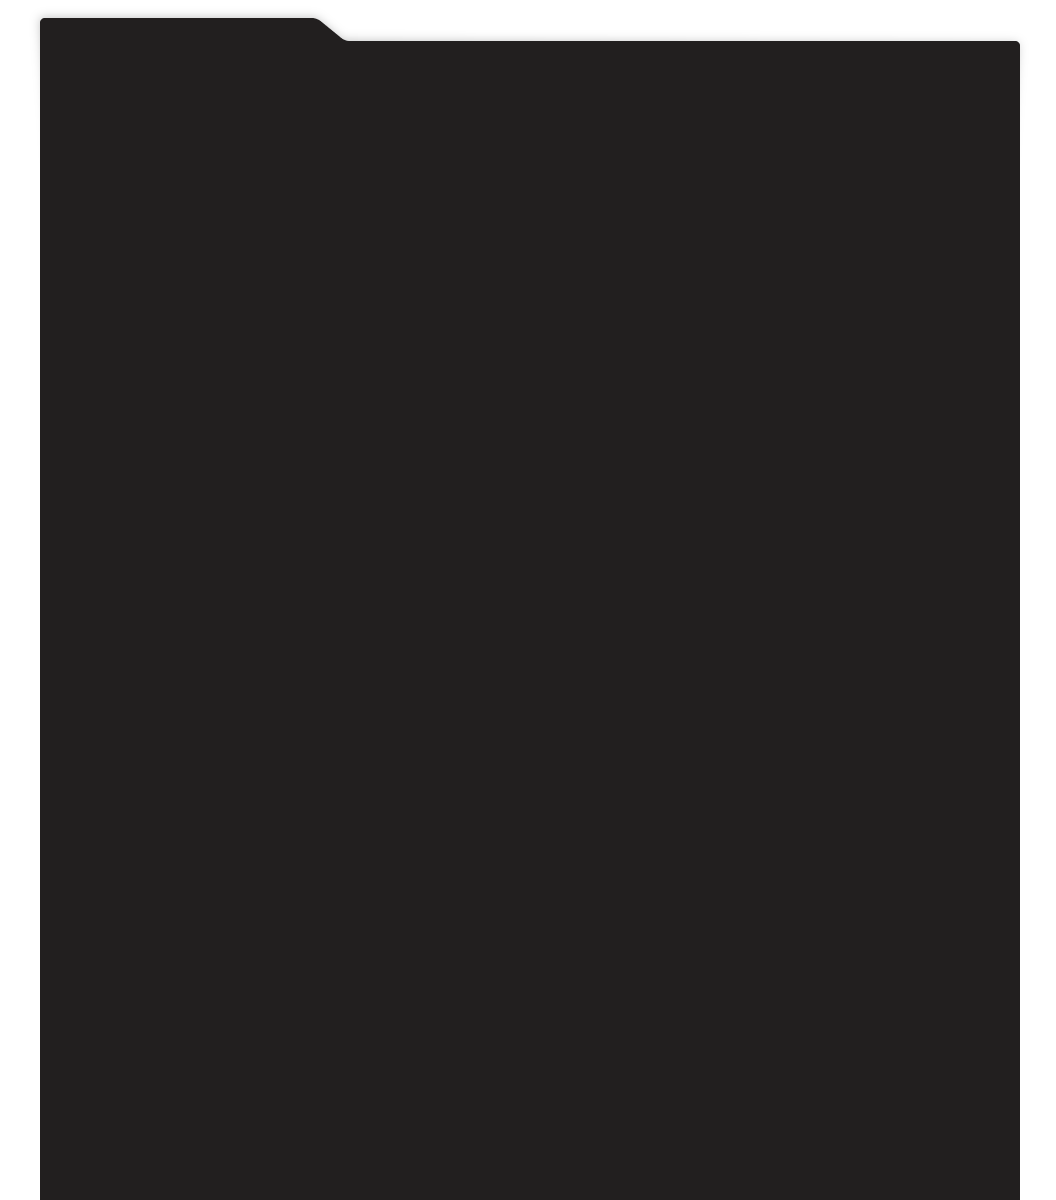
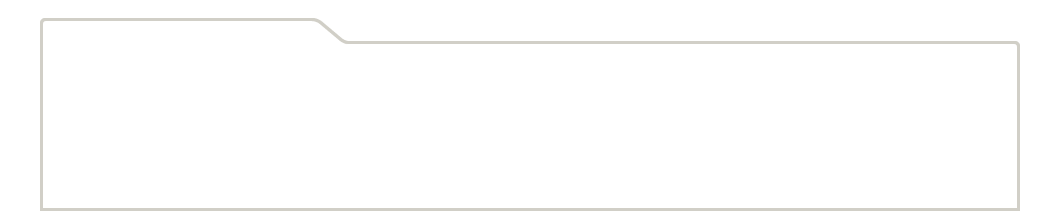
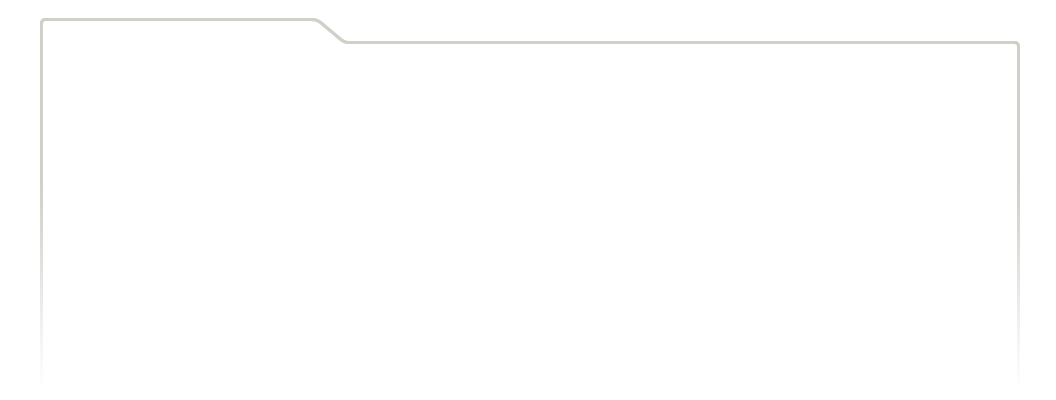
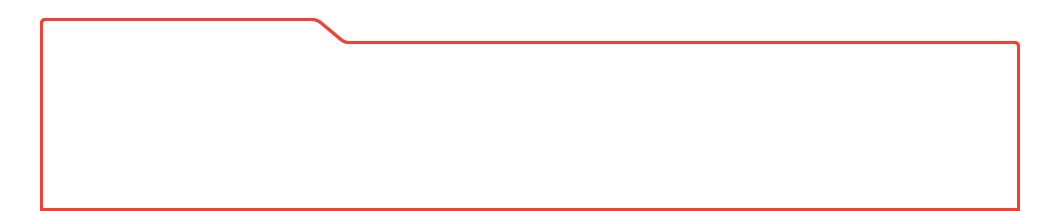
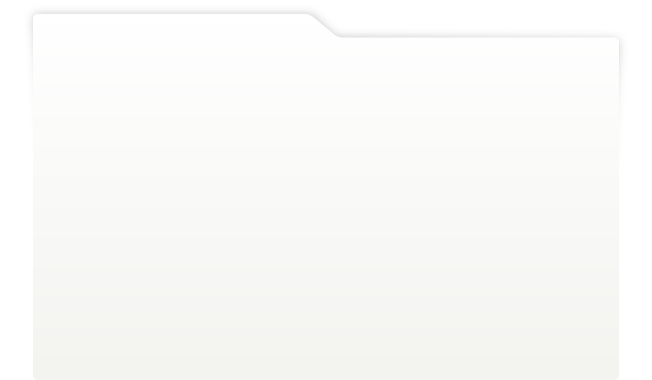
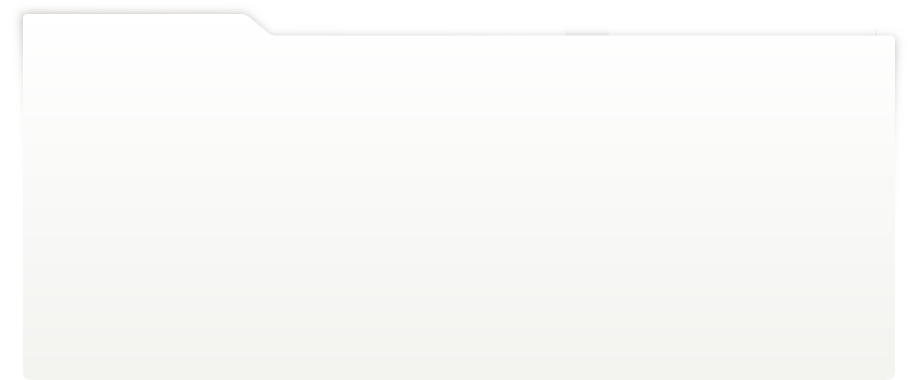
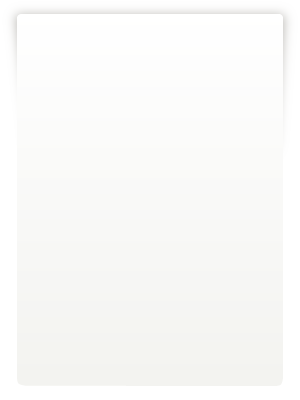
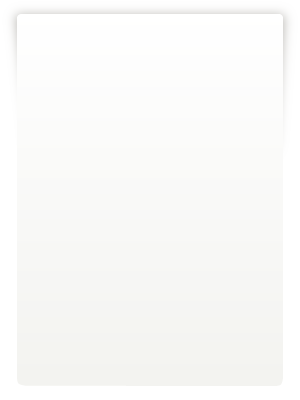
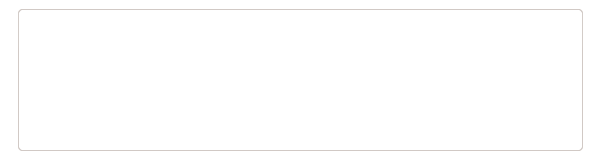
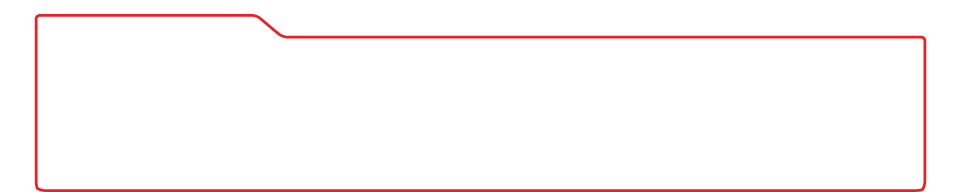
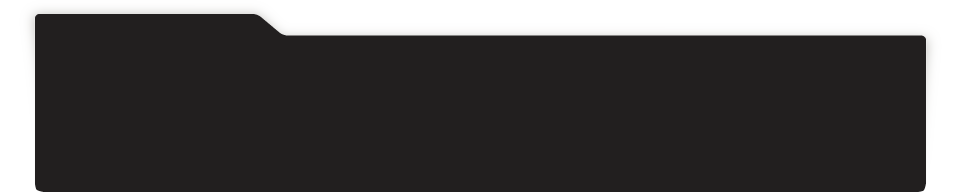
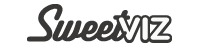
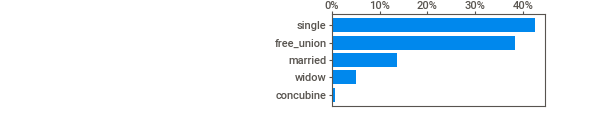
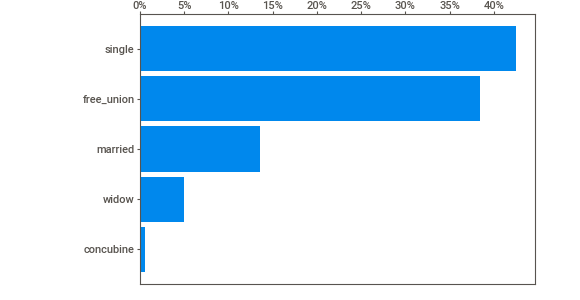
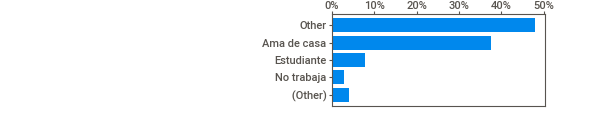
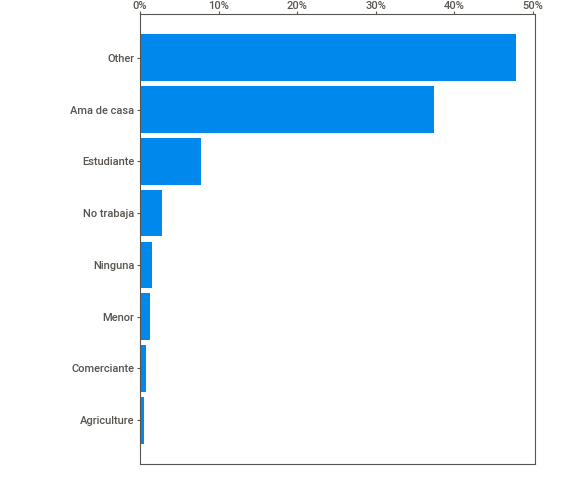
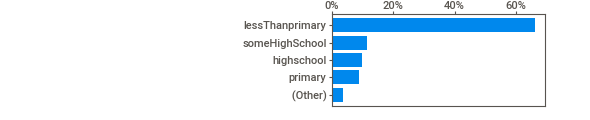
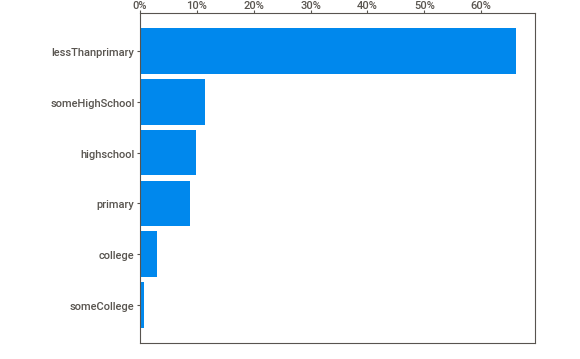
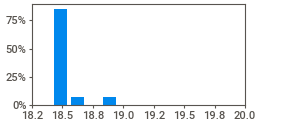
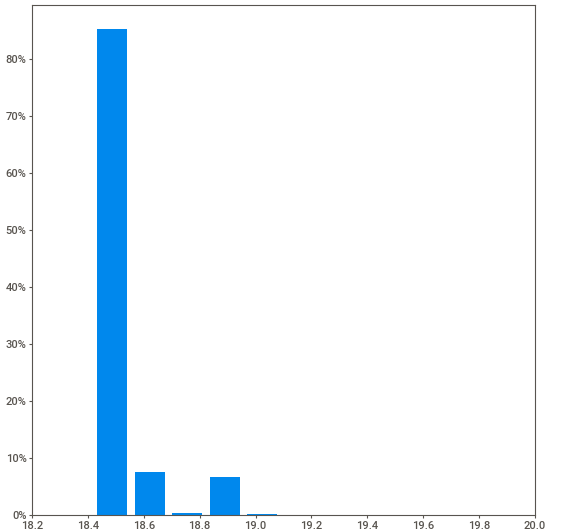
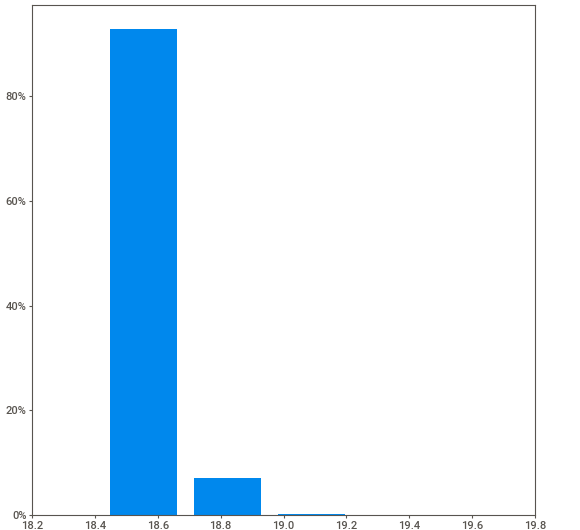
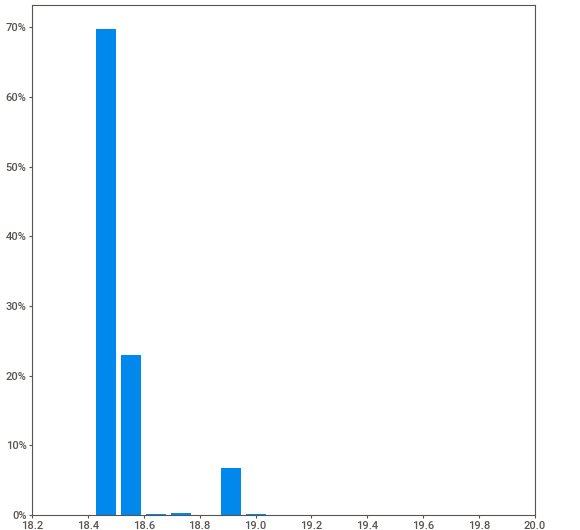
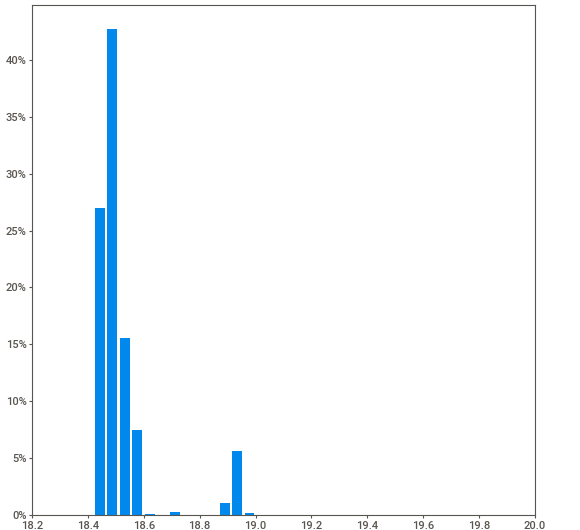
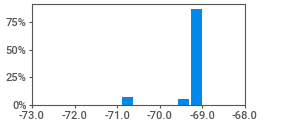
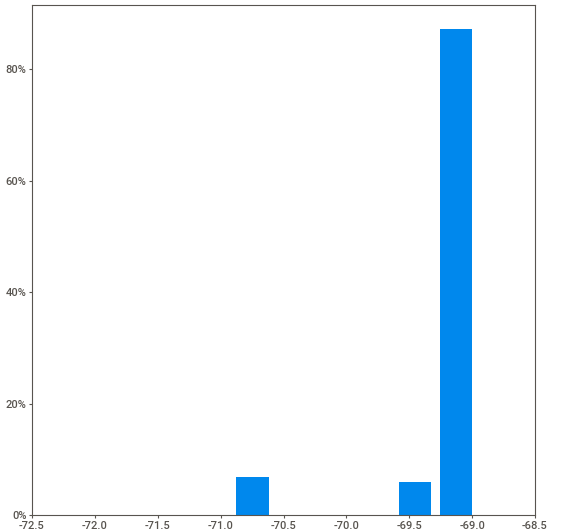
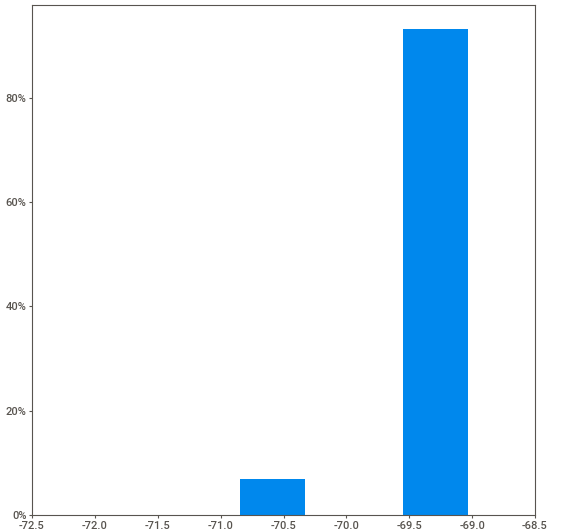
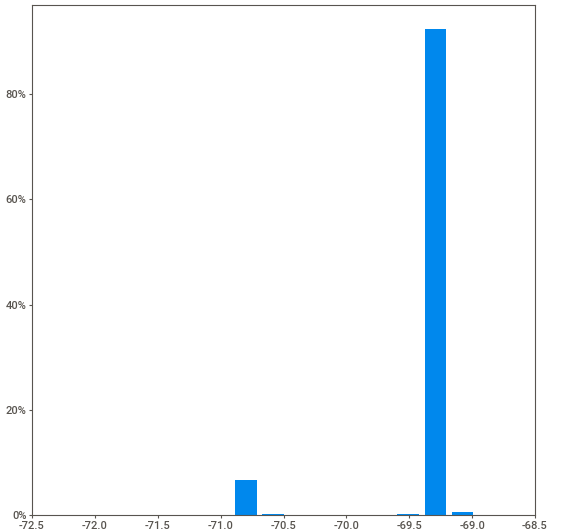
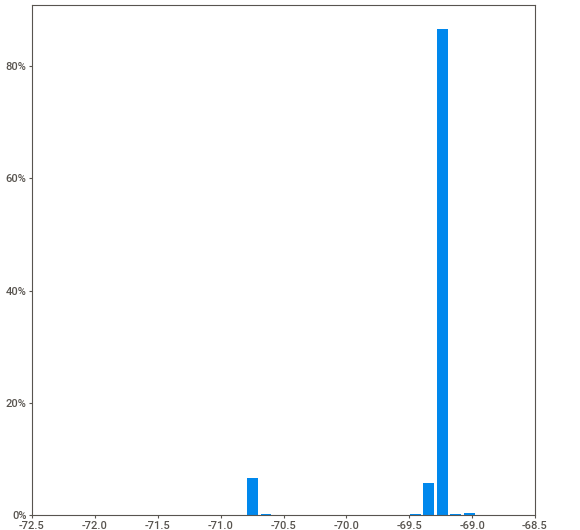
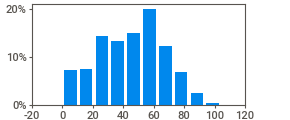
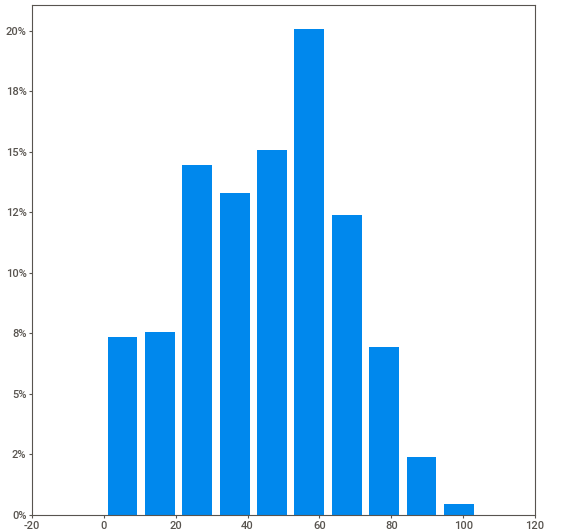
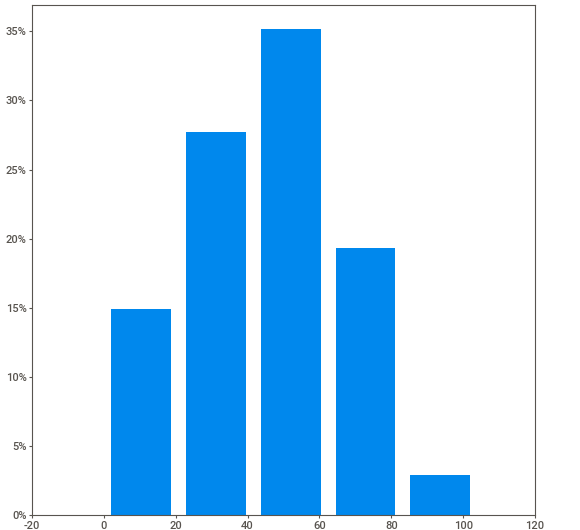
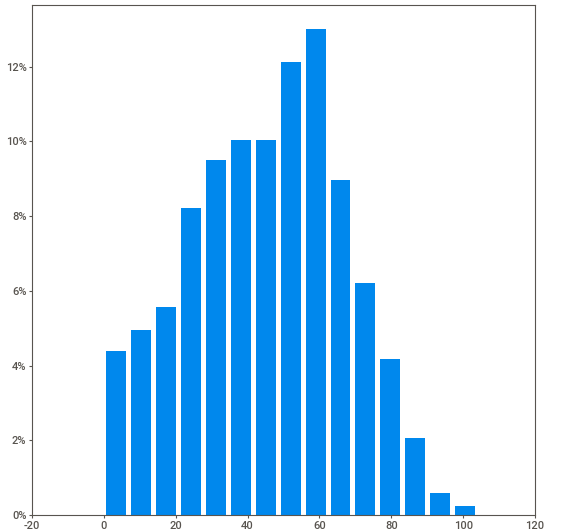
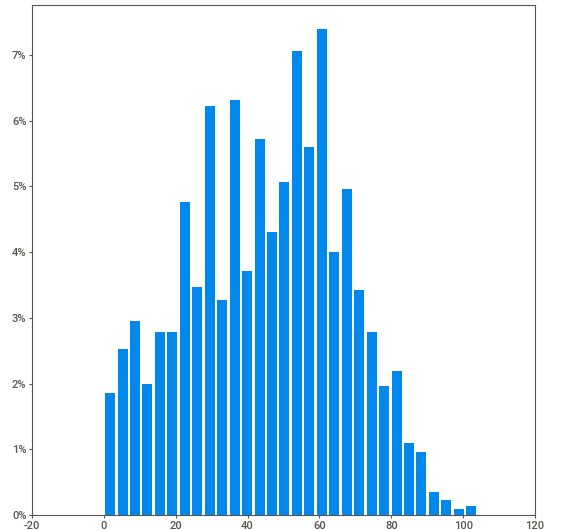
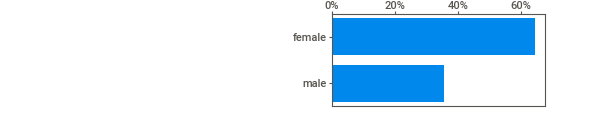
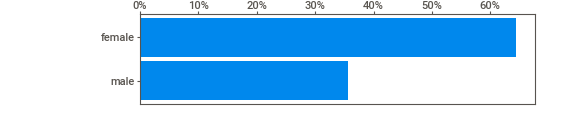
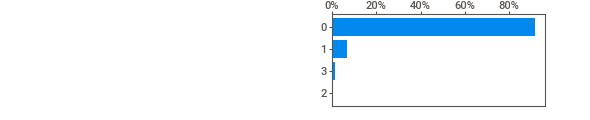
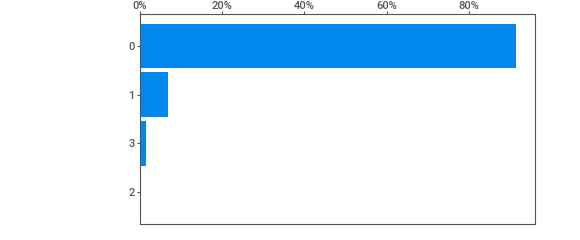
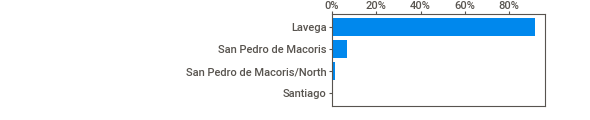
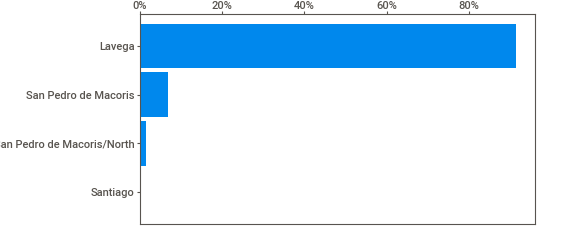
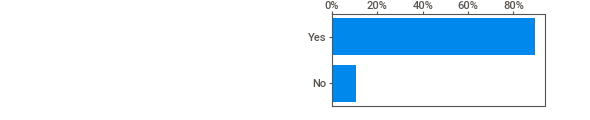
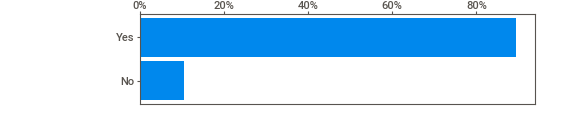
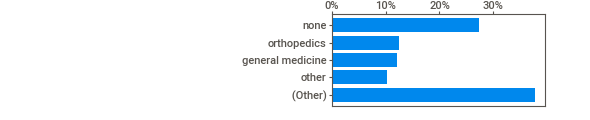
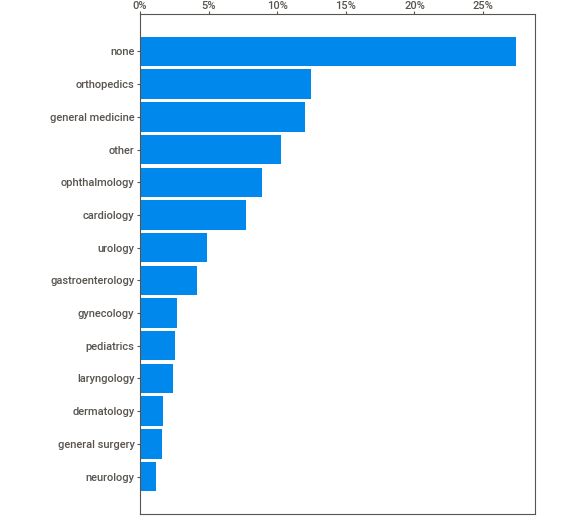
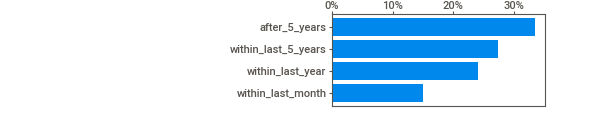
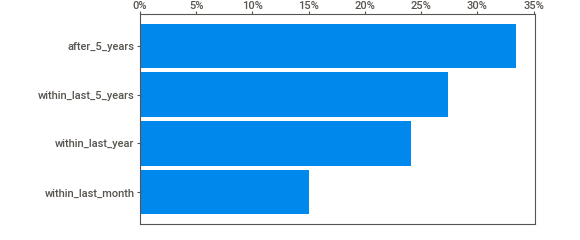
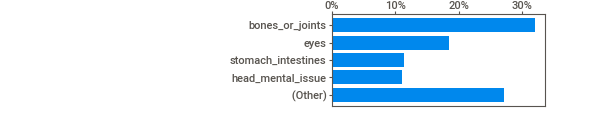
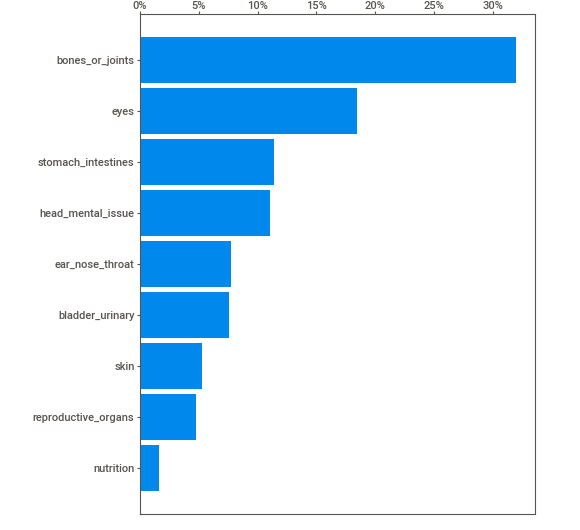
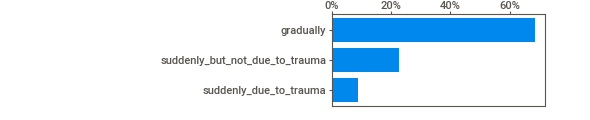
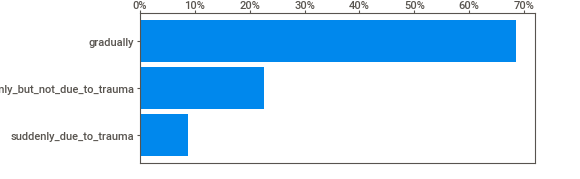
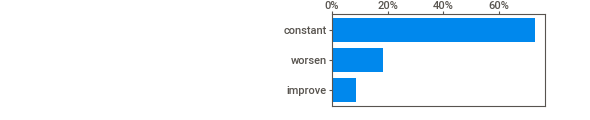
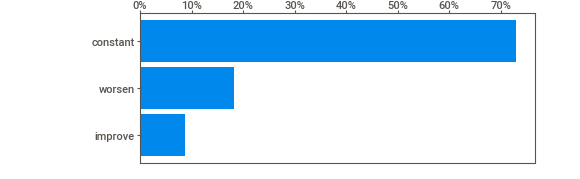
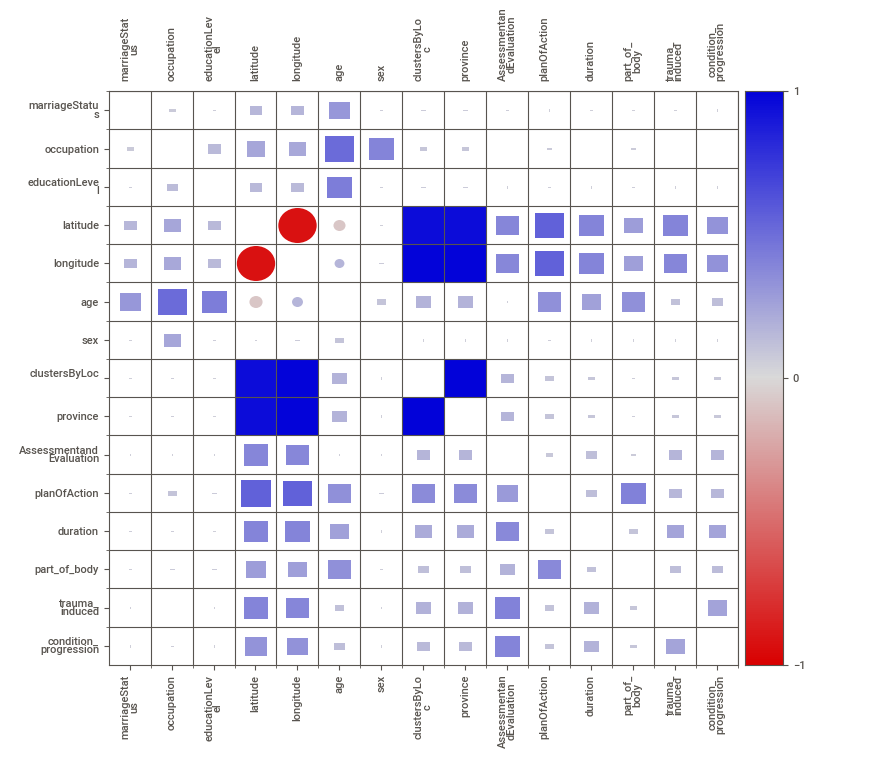
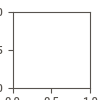

In [207]:
sv_report_survey_med = sv.analyze([survey_med, "Survey_med"])
sv_report_survey_med.show_notebook()

### 3. History_env x eval_med

In [ ]:
env_med = history_env.merge(eval_med, how = "inner", on = "objectId")
env_med.head()

In [66]:
env_med.isna().sum()

objectId                                          0
yearsLivedinThisHouse                            16
waterAccess                                      52
typeofWaterdoyoudrink                            44
latrineAccess                                  2402
conditionoFloorinyourhouse                       77
conditionoRoofinyourhouse                        44
medicalproblemswheredoyougo                       0
dentalproblemswheredoyougo                        0
biggestproblemofcommunity                         0
timesperweektrashcollected                        0
wheretrashleftbetweenpickups                      0
numberofIndividualsLivingintheHouse               0
numberofChildrenLivinginHouseUndertheAgeof5       0
houseownership                                   81
bathroomAccess                                 2310
AssessmentandEvaluation                           0
planOfAction                                      0
duration                                        389
part_of_body